In [16]:
import logging

import numpy as np
import optimistix as optx
from atmodeller import (
    InteriorAtmosphere,
    Planet,
    Species,
    SpeciesCollection,
    debug_logger,
    earth_oceans_to_hydrogen_mass,
    SolverParameters,
)
from atmodeller.eos import get_eos_models
from atmodeller.solubility import get_solubility_models
from atmodeller.thermodata import IronWustiteBuffer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm

from scipy.interpolate import interp1d
import os

from matplotlib.ticker import ScalarFormatter

formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
formatter.set_useOffset(False)
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

logger = debug_logger()
logger.setLevel(logging.INFO)

# For more output use DEBUG
# logger.setLevel(logging.DEBUG)

In [17]:
number_of_realisations = 500
surface_temperature = 2000  # K -> take another temperature, the one aligning with mbe, up to 2-3k kelvin https://link.springer.com/article/10.1007/s11214-020-00660-3
# For simulations with fixed mass and surface radius:
planet_mass = 8e25 #13.4 earth masses for inside boundary (90% somewhat, could be less, reask)
surface_radius = 2.5559e7  # Lindal et al -> Can be discussed, radius of magma envelope boundary -> reduce and deal with incostitent between rocky and ice planets
#will iterate over later, take for now 0.8 r_U (I find results of 0.4-0.9). r_U = 2.5559e7 https://link.springer.com/article/10.1007/s11214-020-00660-3
mantle_melt_fraction = 1.0  # 0.1 -> we will iterate 

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)

#mass constraints given -> https://www.aanda.org/articles/aa/pdf/2021/06/aa40663-21.pdf

In [18]:
H_masspercent_lodders09: float = 73.9
He_masspercent_lodders09: float = 24.69
C_masspercent_lodders09: float = 0.22
N_masspercent_lodders09: float = 0.07
O_masspercent_lodders09: float = 0.63
Si_masspercent_lodders09: float = 0.07

H_logN: float = 12
He_logN: float = 10.93
C_logN: float = 8.39
N_logN: float = 7.86
O_logN: float = 8.73
Si_logN: float = 7.53

In [19]:
#SiO2 for primitive composition of Earth
SiO2_mantlemasspercent_palme14: float = 45.4
total_mantlemasspercent_palme14: float = 98.41
core_mass_fraction: float = 0.327  # typical values used are between 0.325 - 0.33
Si_massfraction_palme14: float = round(
    SiO2_mantlemasspercent_palme14
    / total_mantlemasspercent_palme14
    * (1 - core_mass_fraction)
    / (28.0855 + 2 * 15.999)
    * 28.0855,
    3,
)

O_massfraction_palme14: float = Si_massfraction_palme14 / 28.0855 * 2 * 15.999


hmps = np.logspace(-1, 0, num=number_of_realisations)  # wt% H
h_kgs = hmps / 100 * planet_mass  # kg

si_kg_magma: float = Si_massfraction_palme14 * planet_mass
o_kg_magma: float = O_massfraction_palme14 * planet_mass

# Lodders et al. (2009) Springer book chapter Table 8
si_kgs_solar = h_kgs * Si_masspercent_lodders09 / H_masspercent_lodders09
o_kgs_solar = h_kgs * O_masspercent_lodders09 / H_masspercent_lodders09
c_kgs_solar = h_kgs * C_masspercent_lodders09 / H_masspercent_lodders09
n_kgs_solar = h_kgs * N_masspercent_lodders09 / H_masspercent_lodders09
he_kgs_solar = h_kgs * He_masspercent_lodders09 / H_masspercent_lodders09

In [20]:
eos_models = get_eos_models()
sol_models = get_solubility_models()

H2O_g = Species.create_gas("H2O")
H2O_gs = Species.create_gas("H2O", solubility=sol_models["H2O_peridotite_sossi23"])
H2O_rgs = Species.create_gas(
    "H2O",
    activity=eos_models["H2O_cork_holland98"],
    solubility=sol_models["H2O_peridotite_sossi23"],
)

H2_g = Species.create_gas("H2")
H2_gs = Species.create_gas("H2", solubility=sol_models["H2_basalt_hirschmann12"])
H2_rgs = Species.create_gas(
    "H2", activity=eos_models["H2_chabrier21"], solubility=sol_models["H2_basalt_hirschmann12"]
)

O2_g = Species.create_gas("O2")
O2_rg = Species.create_gas("O2", activity=eos_models["O2_cs_shi92"])

OSi_g = Species.create_gas("OSi")
OSi_rg = Species.create_gas("OSi", activity=eos_models["OSi_rk49_connolly16"])

H4Si_g = Species.create_gas("H4Si")
H4Si_rg = Species.create_gas("H4Si", activity=eos_models["H4Si_wang18"])

O2Si_l = Species.create_condensed("O2Si", state="l")
O2Si_bqz = Species.create_condensed("O2Si", state="bqz")

CO2_g = Species.create_gas("CO2")
CO2_gs = Species.create_gas("CO2", solubility=sol_models["CO2_basalt_dixon95"])
CO2_rgs = Species.create_gas(
    "CO2", solubility=sol_models["CO2_basalt_dixon95"], activity=eos_models["CO2_cs_shi92"]
)

CO_g = Species.create_gas("CO")
CO_gs = Species.create_gas("CO", solubility=sol_models["CO_basalt_yoshioka19"])
CO_rgs = Species.create_gas(
    "CO", solubility=sol_models["CO_basalt_yoshioka19"], activity=eos_models["CO_cs_shi92"]
)

CH4_g = Species.create_gas("CH4")
CH4_gs = Species.create_gas("CH4", solubility=sol_models["CH4_basalt_ardia13"])
CH4_rgs = Species.create_gas(
    "CH4", solubility=sol_models["CH4_basalt_ardia13"], activity=eos_models["CH4_cs_shi92"]
)

N2_g = Species.create_gas("N2")
N2_gs = Species.create_gas("N2", solubility=sol_models["N2_basalt_libourel03"])
N2_rgs = Species.create_gas(
    "N2", solubility=sol_models["N2_basalt_libourel03"], activity=eos_models["N2_cs_saxena87"]
)

NH3_g = Species.create_gas("NH3")
NH3_rg = Species.create_gas("H3N", activity=eos_models["H3N_rk49_reid87"])

He_g = Species.create_gas("He")
He_gs = Species.create_gas("He", solubility=sol_models["He_basalt_jambon86"])
He_rgs = Species.create_gas(
    "He", solubility=sol_models["He_basalt_jambon86"], activity=eos_models["He_chabrier21"]
)


species_HHeCNOSi_magma_nosol_ideal = SpeciesCollection(
    (H2O_g, H2_g, O2_g, OSi_g, H4Si_g, O2Si_l, CO2_g, CO_g, CH4_g, N2_g, NH3_g, He_g)
)
species_HHeCNOSi_magma_sol_ideal = SpeciesCollection(
    (H2O_gs, H2_gs, O2_g, OSi_g, H4Si_g, O2Si_l, CO2_gs, CO_gs, CH4_gs, N2_gs, NH3_g, He_gs)
)
species_HHeCNOSi_magma_sol_real = SpeciesCollection(
    (
        H2O_rgs,
        H2_rgs,
        O2_rg,
        OSi_rg,
        H4Si_rg,
        O2Si_l,
        CO2_rgs,
        CO_rgs,
        CH4_rgs,
        N2_rgs,
        NH3_rg,
        He_rgs,
    )
)

In [21]:
color_tot = "black"
color_H2 = "orange"
color_H2O = "blue"
color_SiH4 = "red"
color_SiO = "brown"
color_O2 = "limegreen"
color_CO2 = "cyan"
color_CO = "magenta"
color_CH4 = "purple"
color_N2 = "green"
color_NH3 = "pink"
color_He = "gray"
color_H = "orange"
color_C = "cyan"
color_N = "green"
color_O = "blue"
color_Si = "red"
#maybe try adding MgSiO3 instead of SiO2 in the future 

In [31]:
def create_models(surface_temperature, planet_mass, mantle_melt_fraction, surface_radius, mass_constraints):
    Uranus = Planet(
            surface_temperature=surface_temperature,
            planet_mass=planet_mass,
            mantle_melt_fraction=mantle_melt_fraction,
            surface_radius=surface_radius,
        )

    model_magma_nosol_ideal = InteriorAtmosphere(species_HHeCNOSi_magma_nosol_ideal)
    model_magma_nosol_ideal.solve(
            planet=Uranus,
            mass_constraints=mass_constraints,
            )
    output_magma_nosol_ideal = model_magma_nosol_ideal.output
    output_magma_nosol_ideal.quick_look()
    output_magma_nosol_ideal.to_excel("HHeCNOSi_magma_nosol_ideal")

    model_magma_sol_ideal = InteriorAtmosphere(species_HHeCNOSi_magma_sol_ideal)
    initial_log_number_density = output_magma_nosol_ideal.log_number_density
    model_magma_sol_ideal.solve(
            planet=Uranus,
            mass_constraints=mass_constraints,
            initial_log_number_density=initial_log_number_density,
            )
    output_magma_sol_ideal = model_magma_sol_ideal.output
    output_magma_sol_ideal.quick_look()
    output_magma_sol_ideal.to_excel("HHeCNOSi_magma_sol_ideal")

    model_magma_sol_real = InteriorAtmosphere(species_HHeCNOSi_magma_sol_real)
    initial_log_number_density = output_magma_sol_ideal.log_number_density
    model_magma_sol_real.solve(
            planet=Uranus,
            mass_constraints=mass_constraints,
            initial_log_number_density=initial_log_number_density,
            )
    output_magma_sol_real = model_magma_sol_real.output
    output_magma_sol_real.quick_look()
    output_magma_sol_real.to_excel("HHeCNOSi_magma_sol_real")

    filename = "HHeCNOSi_magma_sol_real.xlsx"
    
    H2_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H2_g")["pressure"]
    H2O_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H2O_g")["pressure"]
    O2_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="O2_g")["pressure"]
    SiH4_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H4Si_g")["pressure"]
    SiO_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="OSi_g")["pressure"]
    CO2_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="CO2_g")["pressure"]
    CO_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="CO_g")["pressure"]
    CH4_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="CH4_g")["pressure"]
    N2_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="N2_g")["pressure"]
    NH3_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H3N_g")["pressure"]
    He_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="He_g")["pressure"]
    tot_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

    H_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["atmosphere_moles"]
    O_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["atmosphere_moles"]
    Si_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["atmosphere_moles"]
    C_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_C")["atmosphere_moles"]
    He_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_He")["atmosphere_moles"]
    N_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_N")["atmosphere_moles"]

    H_moles_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["dissolved_moles"]
    O_moles_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["dissolved_moles"]
    Si_moles_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["dissolved_moles"]
    C_moles_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_C")["dissolved_moles"]
    He_moles_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_He")["dissolved_moles"]
    N_moles_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_N")["dissolved_moles"]

    H_moles_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["total_moles"]
    O_moles_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["total_moles"]
    Si_moles_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["total_moles"]
    C_moles_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_C")["total_moles"]
    He_moles_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_He")["total_moles"]
    N_moles_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_N")["total_moles"]

    H_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["atmosphere_mass"]
    O_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["atmosphere_mass"]
    Si_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["atmosphere_mass"]
    C_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_C")["atmosphere_mass"]
    He_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_He")["atmosphere_mass"]
    N_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_N")["atmosphere_mass"]

    H_mass_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["dissolved_mass"]
    O_mass_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["dissolved_mass"]
    Si_mass_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["dissolved_mass"]
    C_mass_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_C")["dissolved_mass"]
    He_mass_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_He")["dissolved_mass"]
    N_mass_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_N")["dissolved_mass"]

    H_mass_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["total_mass"]
    O_mass_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["total_mass"]
    Si_mass_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["total_mass"]
    C_mass_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_C")["total_mass"]
    He_mass_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_He")["total_mass"]
    N_mass_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_N")["total_mass"]

    fig, axes = plt.subplots(3, 3, figsize=(10, 8))
    axes = axes.flatten()  # flatten 2D array of axes to 1D list

    axes[0].plot(hmps, tot_pressure_magma_sol_real, color=color_tot, lw=4, ls="-", label="Total")
    axes[0].plot(hmps, H2_pressure_magma_sol_real, color=color_H2, lw=3, ls="-", label="H$_2$")
    axes[0].plot(hmps, H2O_pressure_magma_sol_real, color=color_H2O, lw=3, ls="-", label="H$_2$O")
    axes[0].plot(hmps, SiH4_pressure_magma_sol_real, color=color_SiH4, lw=3, ls="-", label="SiH$_4$")
    axes[0].plot(hmps, SiO_pressure_magma_sol_real, color=color_SiO, lw=3, ls="-", label="SiO")
    axes[0].plot(hmps, CO2_pressure_magma_sol_real, color=color_CO2, lw=4, ls="-", label="CO$_2$")
    axes[0].plot(hmps, CO_pressure_magma_sol_real, color=color_CO, lw=3, ls="-", label="CO")
    axes[0].plot(hmps, CH4_pressure_magma_sol_real, color=color_CH4, lw=3, ls="-", label="CH$_4$")
    axes[0].plot(hmps, N2_pressure_magma_sol_real, color=color_N2, lw=3, ls="-", label="N$_2$")
    axes[0].plot(hmps, NH3_pressure_magma_sol_real, color=color_NH3, lw=3, ls="-", label="NH$_3$")
    axes[0].plot(hmps, He_pressure_magma_sol_real, color=color_He, lw=3, ls="-", label="He")
    axes[0].plot(hmps, tot_pressure_magma_sol_real, color=color_tot, lw=3, ls="-", label="tot")
    # ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

    axes[0].set_title(r"(a) Ideal gases with sol")
    axes[0].set_ylim([1e0, 2e5])
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    axes[0].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
    axes[0].set_ylabel(r"MEB Partial Pressure [bar]", fontsize=12)
    axes[0].set_xticks([0.1, 0.3, 1])
    axes[0].get_xaxis().set_major_formatter(ScalarFormatter())

    axes[0].legend(fontsize=10, loc='best') 
    ax0 = axes[0].twinx()
    ax0.set_yscale("log")
    ax0.set_ylabel(r"MEB Partial Pressure [GPa]", fontsize=12)
    ax0.set_ylim([1e-4, 2e1])


    axes[1].plot(hmps, H_moles_atm_magma_sol_real, color=color_H, lw=4, ls="-", label="H")
    axes[1].plot(hmps, O_moles_atm_magma_sol_real, color=color_O, lw=3, ls="-", label="O")
    axes[1].plot(hmps, Si_moles_atm_magma_sol_real, color=color_Si, lw=3, ls="-", label="Si")
    axes[1].plot(hmps, C_moles_atm_magma_sol_real, color=color_C, lw=4, ls="-", label="C")
    axes[1].plot(hmps, He_moles_atm_magma_sol_real, color=color_He, lw=3, ls="-", label="He")
    axes[1].plot(hmps, N_moles_atm_magma_sol_real, color=color_N, lw=3, ls="-", label="N")
    # ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

    #axes[1].set_ylim([1e0, 2e5])
    axes[1].set_xscale("log")
    axes[1].set_yscale("log")
    axes[1].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
    axes[1].set_ylabel("Atmosphere moles", fontsize=12)
    axes[1].set_xticks([0.1, 0.3, 1])
    axes[1].get_xaxis().set_major_formatter(ScalarFormatter())
    axes[1].legend(fontsize=10, loc='best') 


    axes[2].plot(hmps, H_moles_melt_magma_sol_real, color=color_H, lw=4, ls="-", label="H")
    axes[2].plot(hmps, O_moles_melt_magma_sol_real, color=color_O, lw=3, ls="-", label="O")
    axes[2].plot(hmps, Si_moles_melt_magma_sol_real, color=color_Si, lw=3, ls="-", label="Si")
    axes[2].plot(hmps, C_moles_melt_magma_sol_real, color=color_C, lw=4, ls="-", label="C")
    axes[2].plot(hmps, He_moles_melt_magma_sol_real, color=color_He, lw=3, ls="-", label="He")
    axes[2].plot(hmps, N_moles_melt_magma_sol_real, color=color_N, lw=3, ls="-", label="N")
    # ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

    #axes[1].set_ylim([1e0, 2e5])
    axes[2].set_xscale("log")
    axes[2].set_yscale("log")
    axes[2].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
    axes[2].set_ylabel("Dissolved moles", fontsize=12)
    axes[2].set_xticks([0.1, 0.3, 1])
    axes[2].get_xaxis().set_major_formatter(ScalarFormatter())
    axes[2].legend(fontsize=10, loc='best') 


    axes[3].plot(hmps, H_moles_tot_magma_sol_real, color=color_H, lw=4, ls="-", label="H")
    axes[3].plot(hmps, O_moles_tot_magma_sol_real, color=color_O, lw=3, ls="-", label="O")
    axes[3].plot(hmps, Si_moles_tot_magma_sol_real, color=color_Si, lw=3, ls="-", label="Si")
    axes[3].plot(hmps, C_moles_tot_magma_sol_real, color=color_C, lw=4, ls="-", label="C")
    axes[3].plot(hmps, He_moles_tot_magma_sol_real, color=color_He, lw=3, ls="-", label="He")
    axes[3].plot(hmps, N_moles_tot_magma_sol_real, color=color_N, lw=3, ls="-", label="N")
    # ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

    #axes[1].set_ylim([1e0, 2e5])
    axes[3].set_xscale("log")
    axes[3].set_yscale("log")
    axes[3].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
    axes[3].set_ylabel("Total moles", fontsize=12)
    axes[3].set_xticks([0.1, 0.3, 1])
    axes[3].get_xaxis().set_major_formatter(ScalarFormatter())
    axes[3].legend(fontsize=10, loc='best') 


    axes[4].plot(hmps, H_mass_atm_magma_sol_real, color=color_H, lw=4, ls="-", label="H")
    axes[4].plot(hmps, O_mass_atm_magma_sol_real, color=color_O, lw=3, ls="-", label="O")
    axes[4].plot(hmps, Si_mass_atm_magma_sol_real, color=color_Si, lw=3, ls="-", label="Si")
    axes[4].plot(hmps, C_mass_atm_magma_sol_real, color=color_C, lw=4, ls="-", label="C")
    axes[4].plot(hmps, He_mass_atm_magma_sol_real, color=color_He, lw=3, ls="-", label="He")
    axes[4].plot(hmps, N_mass_atm_magma_sol_real, color=color_N, lw=3, ls="-", label="N")
    # ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

    #axes[1].set_ylim([1e0, 2e5])
    axes[4].set_xscale("log")
    axes[4].set_yscale("log")
    axes[4].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
    axes[4].set_ylabel("Atmosphere mass", fontsize=12)
    axes[4].set_xticks([0.1, 0.3, 1])
    axes[4].get_xaxis().set_major_formatter(ScalarFormatter())
    axes[4].legend(fontsize=10, loc='best') 


    axes[5].plot(hmps, H_mass_melt_magma_sol_real, color=color_H, lw=4, ls="-", label="H")
    axes[5].plot(hmps, O_mass_melt_magma_sol_real, color=color_O, lw=3, ls="-", label="O")
    axes[5].plot(hmps, Si_mass_melt_magma_sol_real, color=color_Si, lw=3, ls="-", label="Si")
    axes[5].plot(hmps, C_mass_melt_magma_sol_real, color=color_C, lw=4, ls="-", label="C")
    axes[5].plot(hmps, He_mass_melt_magma_sol_real, color=color_He, lw=3, ls="-", label="He")
    axes[5].plot(hmps, N_mass_melt_magma_sol_real, color=color_N, lw=3, ls="-", label="N")
    # ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

    #axes[1].set_ylim([1e0, 2e5])
    axes[5].set_xscale("log")
    axes[5].set_yscale("log")
    axes[5].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
    axes[5].set_ylabel("Dissolved mass", fontsize=12)
    axes[5].set_xticks([0.1, 0.3, 1])
    axes[5].get_xaxis().set_major_formatter(ScalarFormatter())
    axes[5].legend(fontsize=10, loc='best') 


    axes[6].plot(hmps, H_mass_tot_magma_sol_real, color=color_H, lw=4, ls="-", label="H")
    axes[6].plot(hmps, O_mass_tot_magma_sol_real, color=color_O, lw=3, ls="-", label="O")
    axes[6].plot(hmps, Si_mass_tot_magma_sol_real, color=color_Si, lw=3, ls="-", label="Si")
    axes[6].plot(hmps, C_mass_tot_magma_sol_real, color=color_C, lw=4, ls="-", label="C")
    axes[6].plot(hmps, He_mass_tot_magma_sol_real, color=color_He, lw=3, ls="-", label="He")
    axes[6].plot(hmps, N_mass_tot_magma_sol_real, color=color_N, lw=3, ls="-", label="N")
    # ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

    #axes[1].set_ylim([1e0, 2e5])
    axes[6].set_xscale("log")
    axes[6].set_yscale("log")
    axes[6].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
    axes[6].set_ylabel("Total mass", fontsize=12)
    axes[6].set_xticks([0.1, 0.3, 1])
    axes[6].get_xaxis().set_major_formatter(ScalarFormatter())
    axes[6].legend(fontsize=10, loc='best') 

    # Hide unused subplots
    for j in range(7, 9):
        axes[j].axis("off")

    plt.tight_layout()
    title = f"Uranus Interior: {metall:.0f}× Solar Metallicity, T ≈ {surface_temperature:.0f} K"
    filename = f"./images/uranus_{metall:.0f}xsolar_{surface_temperature:.0f}K.png"

    plt.title(title)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

[20:08:56 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:08:56 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:08:56 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:08:56 - atmodeller.classes             - IN

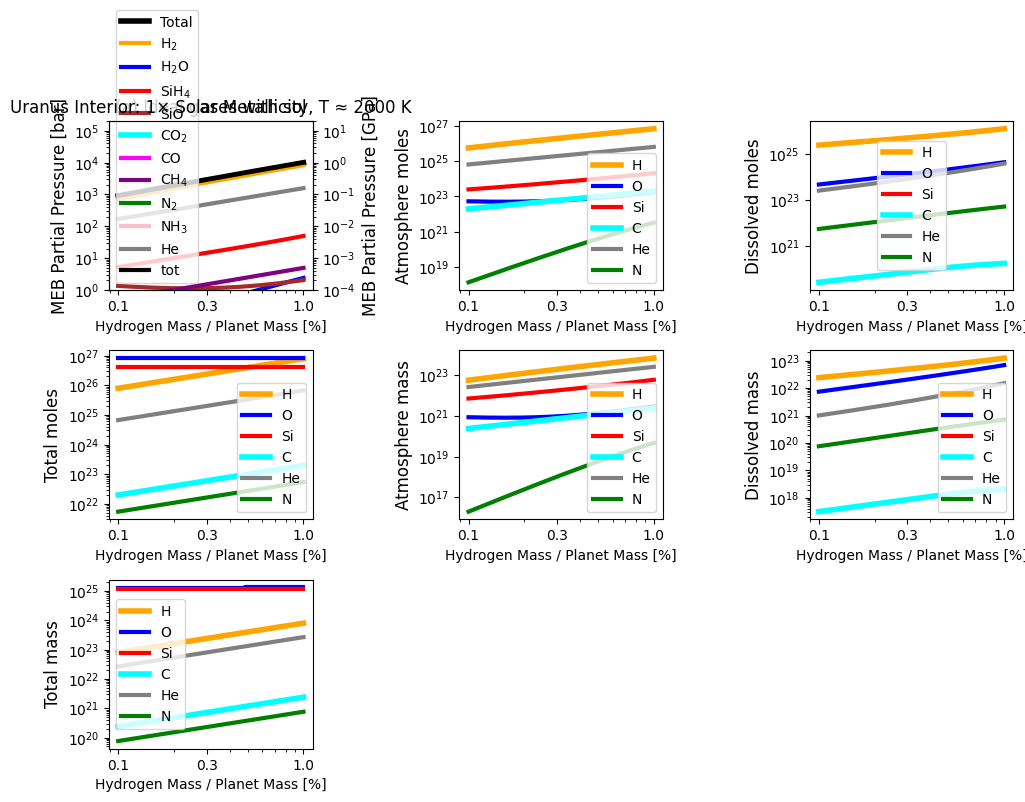

[20:09:30 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:09:30 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:09:30 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:09:30 - atmodeller.classes             - IN

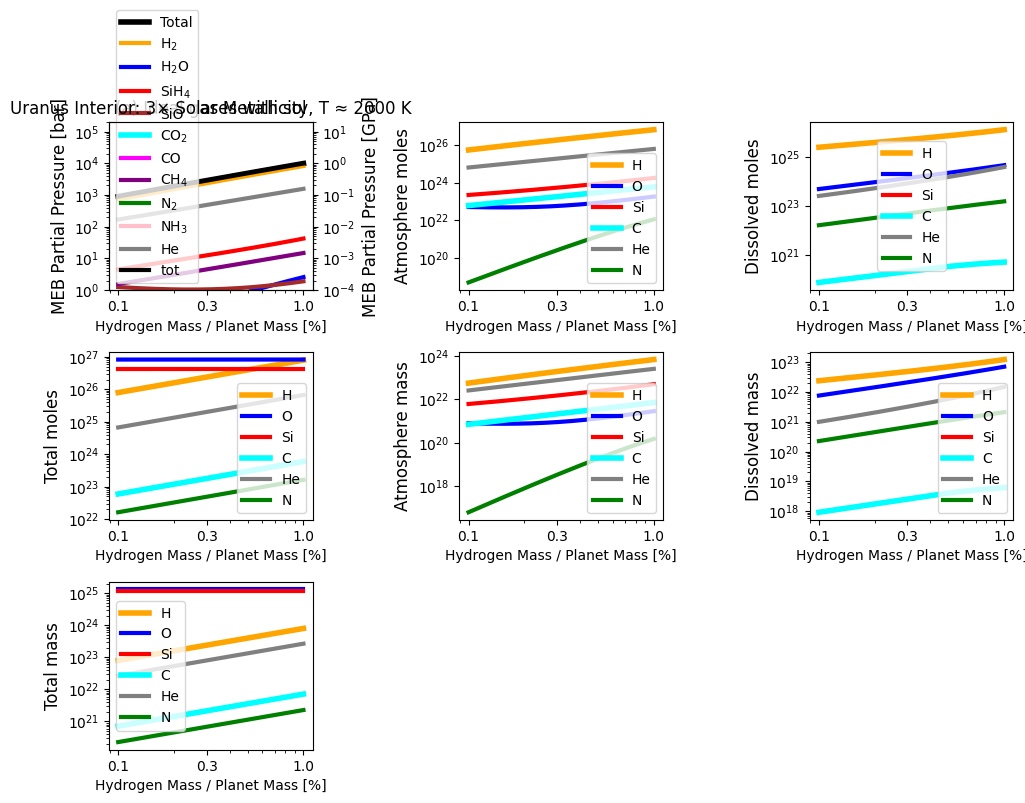

[20:10:03 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:10:03 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:10:03 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:10:03 - atmodeller.classes             - IN

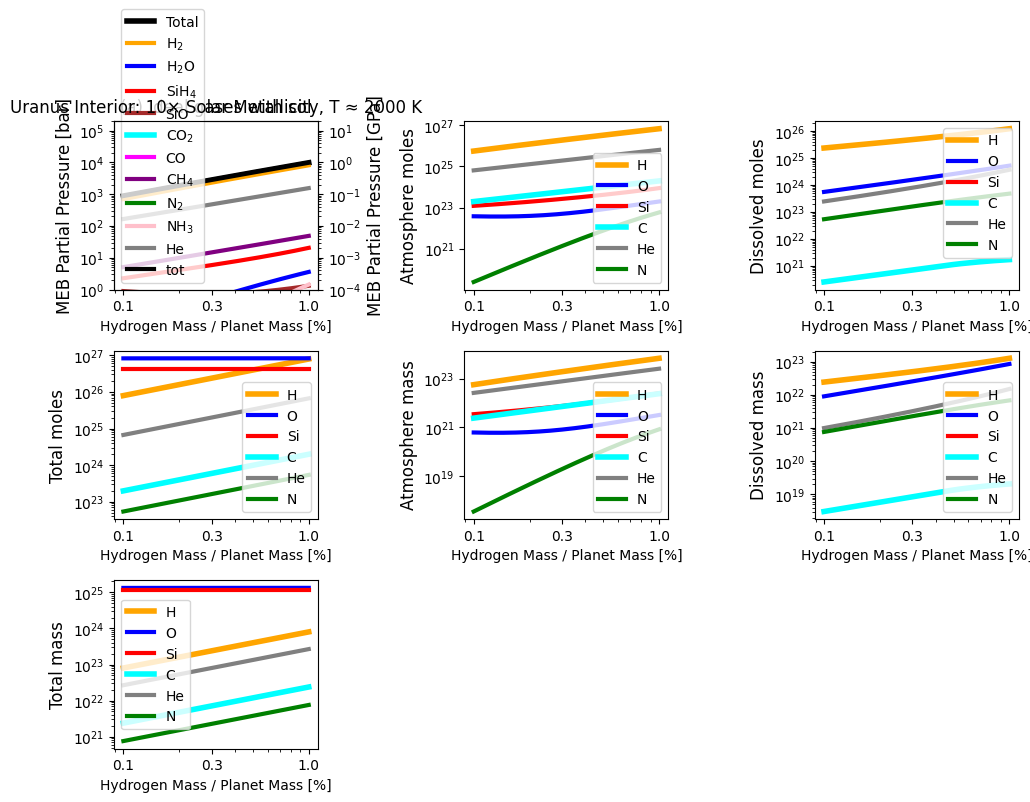

[20:10:39 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:10:39 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:10:39 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:10:39 - atmodeller.classes             - IN

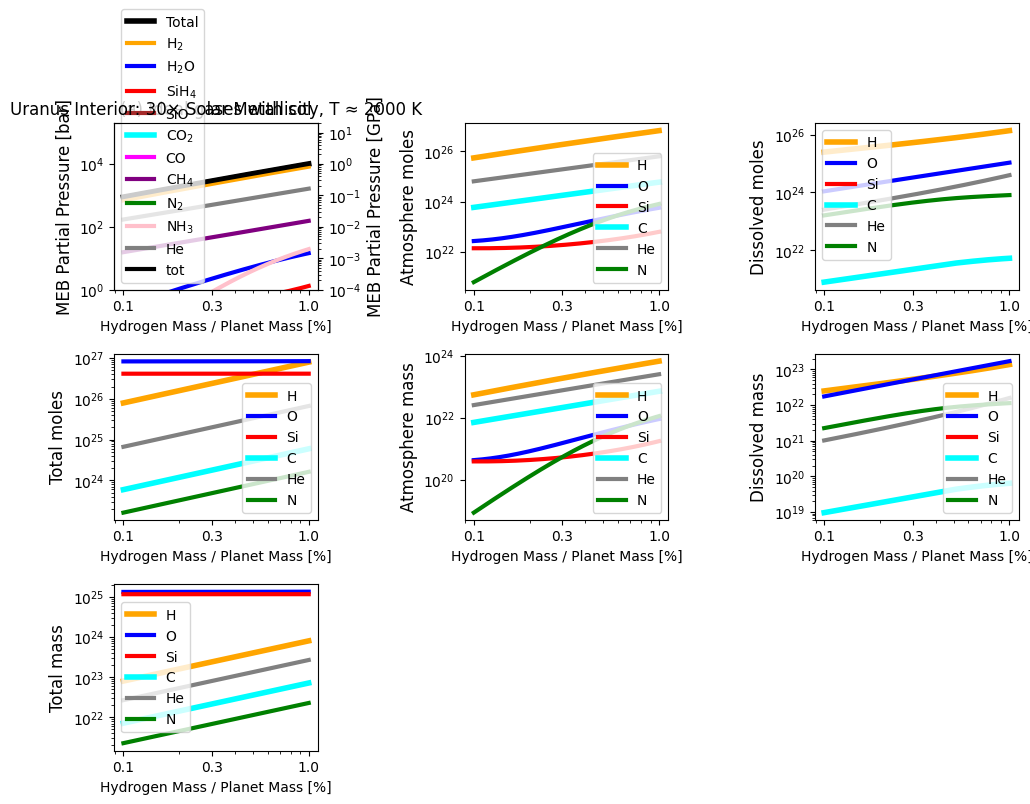

[20:11:16 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:11:16 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:11:16 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:11:16 - atmodeller.classes             - IN

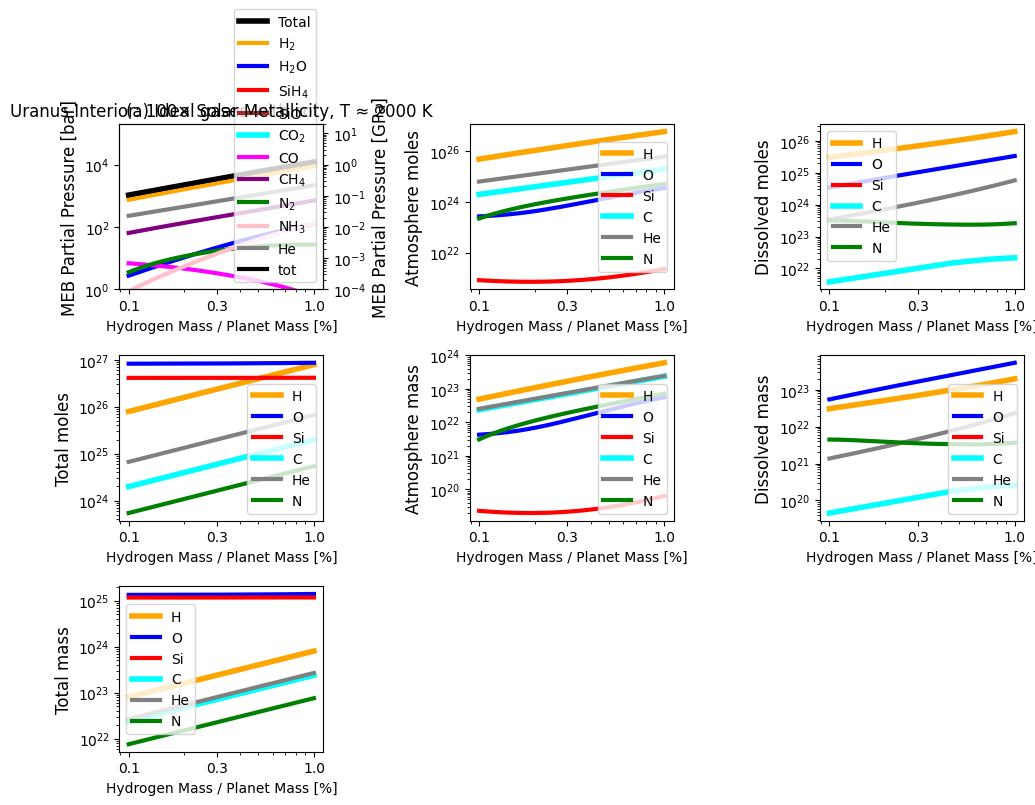

[20:11:50 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:11:50 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:11:50 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:11:50 - atmodeller.classes             - IN

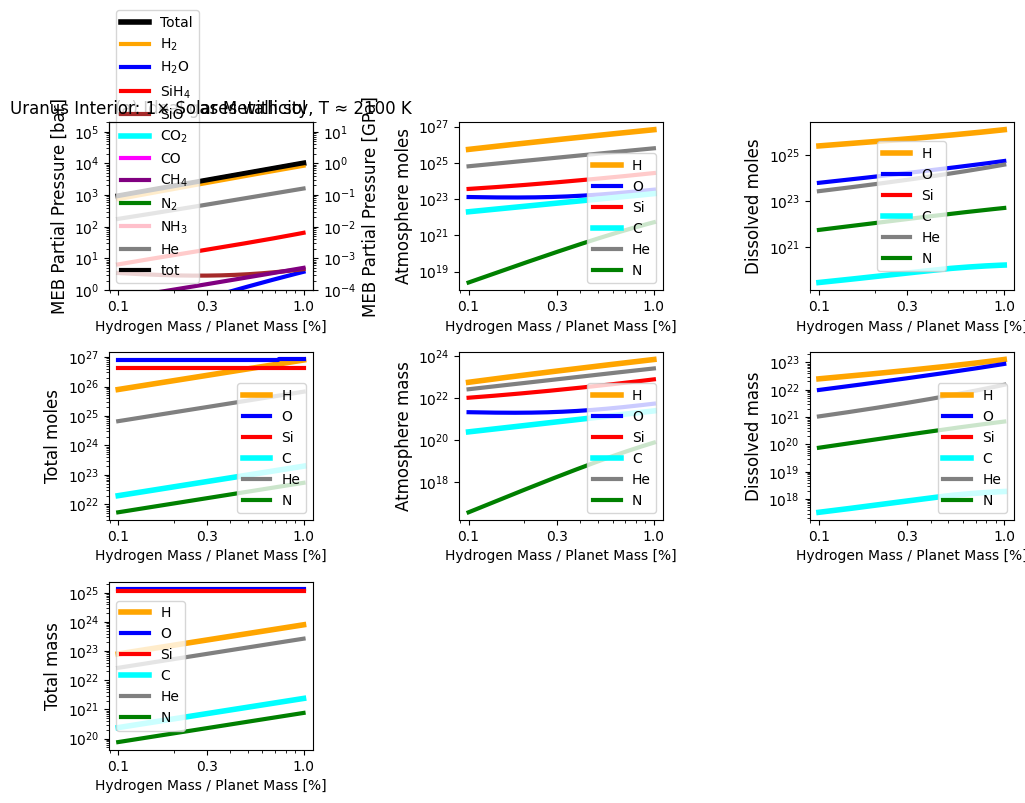

[20:12:23 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:12:23 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:12:23 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:12:23 - atmodeller.classes             - IN

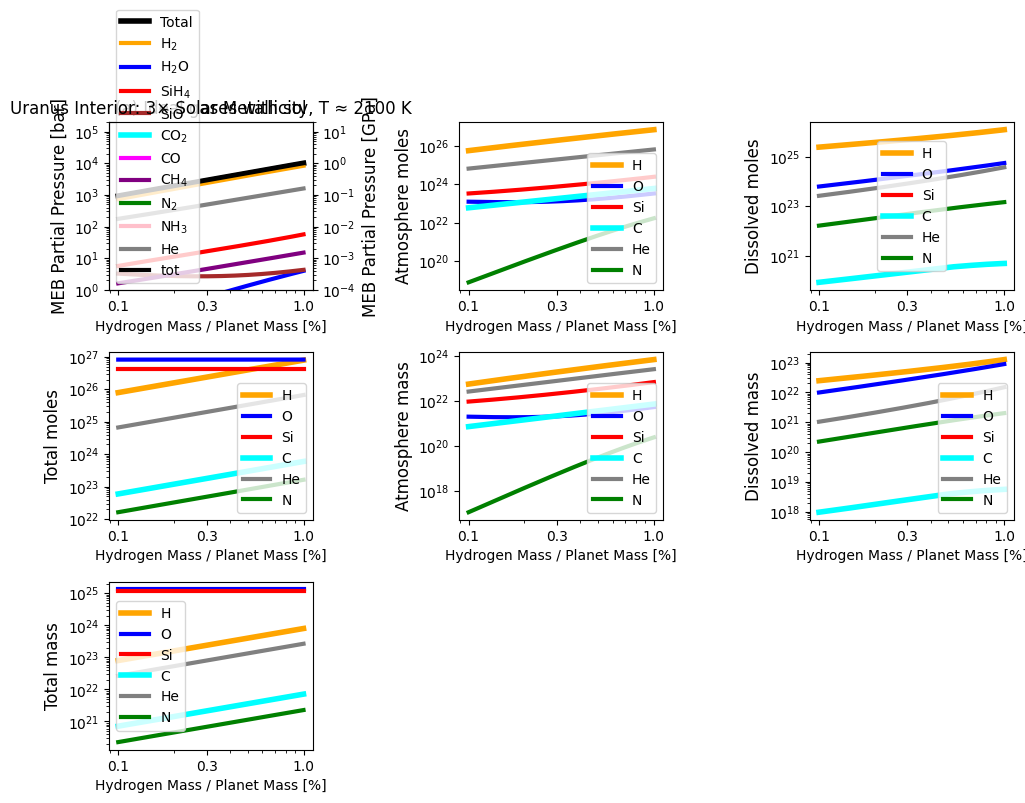

[20:12:59 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:12:59 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:12:59 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:12:59 - atmodeller.classes             - IN

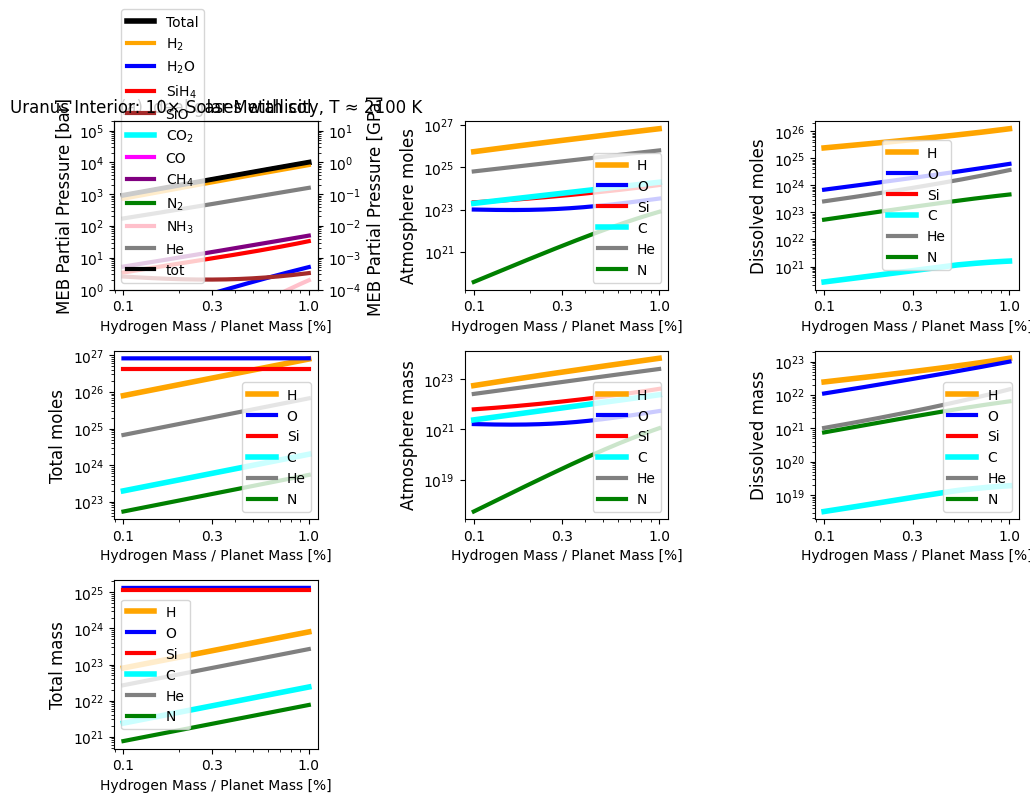

[20:13:34 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:13:34 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:13:34 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:13:34 - atmodeller.classes             - IN

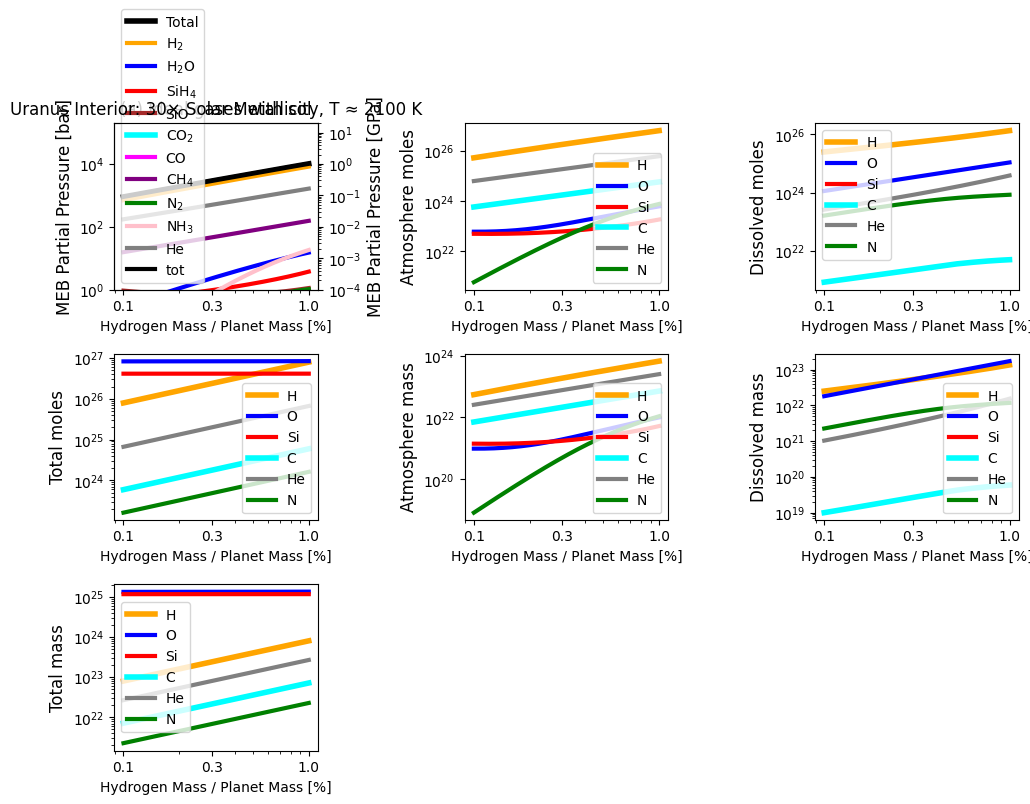

[20:14:17 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:14:17 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:14:17 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:14:17 - atmodeller.classes             - IN

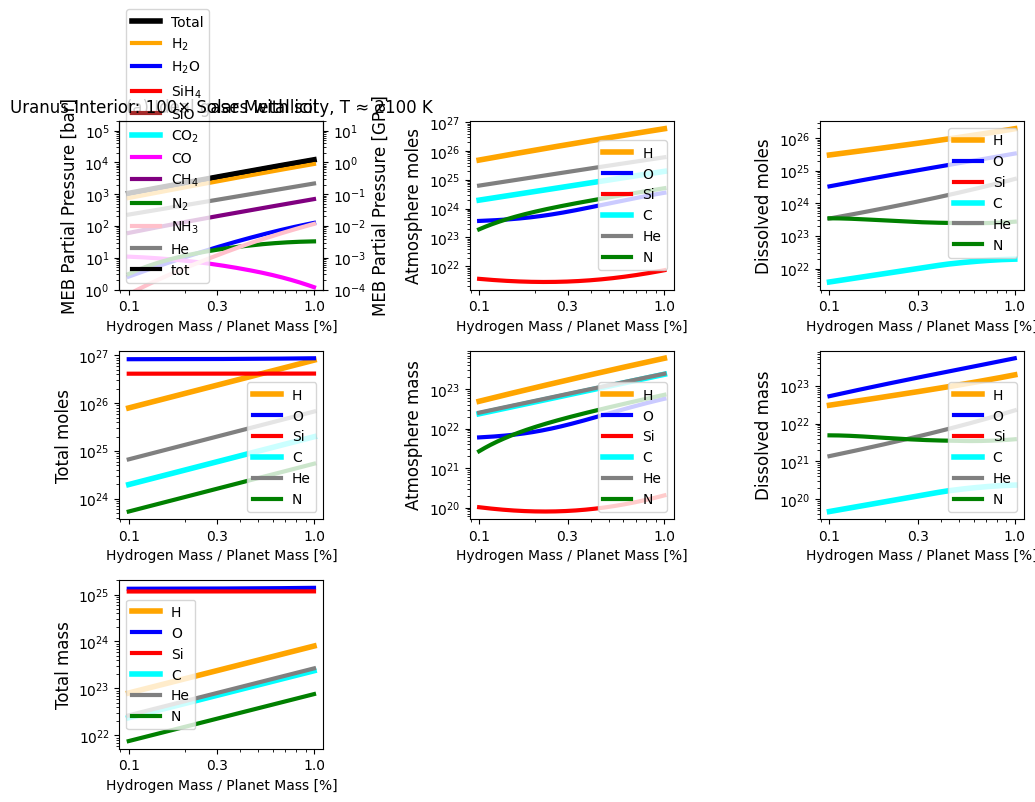

[20:14:53 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:14:53 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:14:53 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:14:54 - atmodeller.classes             - IN

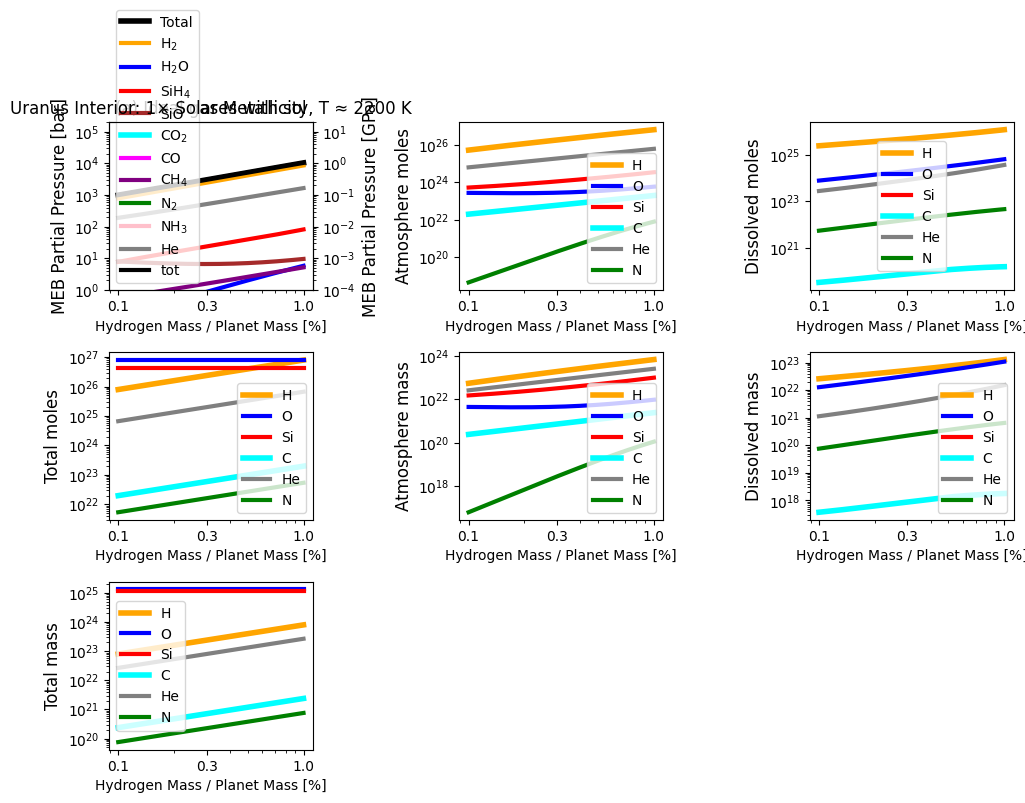

[20:15:34 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:15:34 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:15:34 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:15:34 - atmodeller.classes             - IN

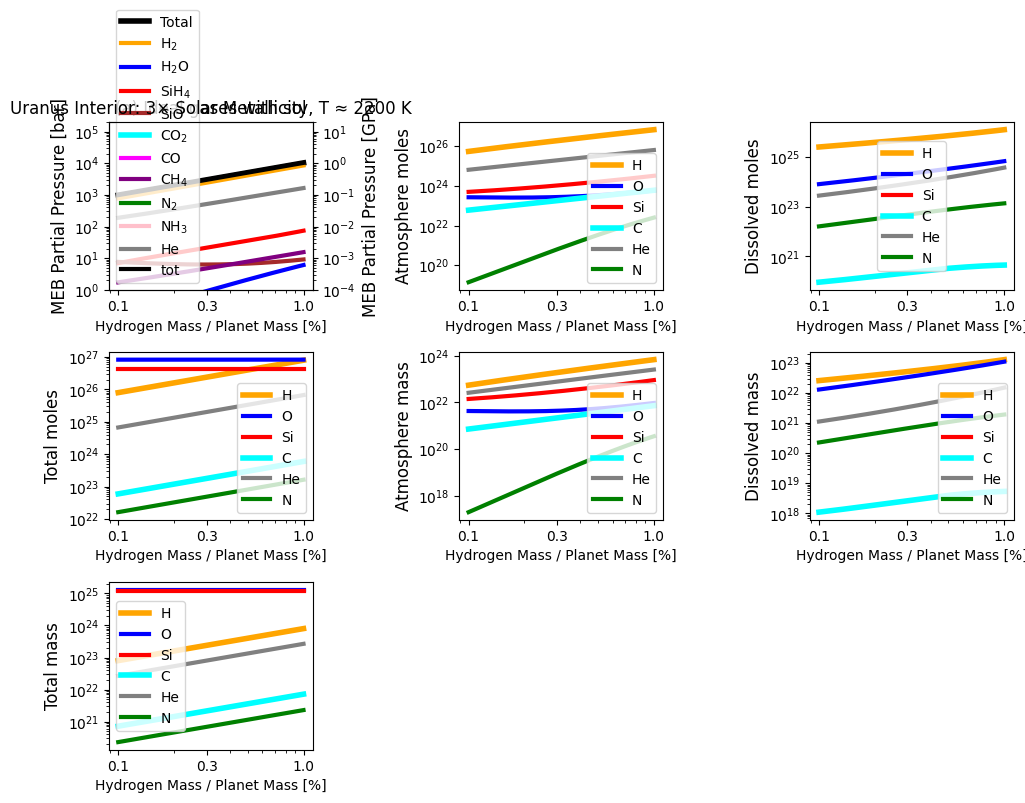

[20:16:10 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:16:10 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:16:10 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:16:11 - atmodeller.classes             - IN

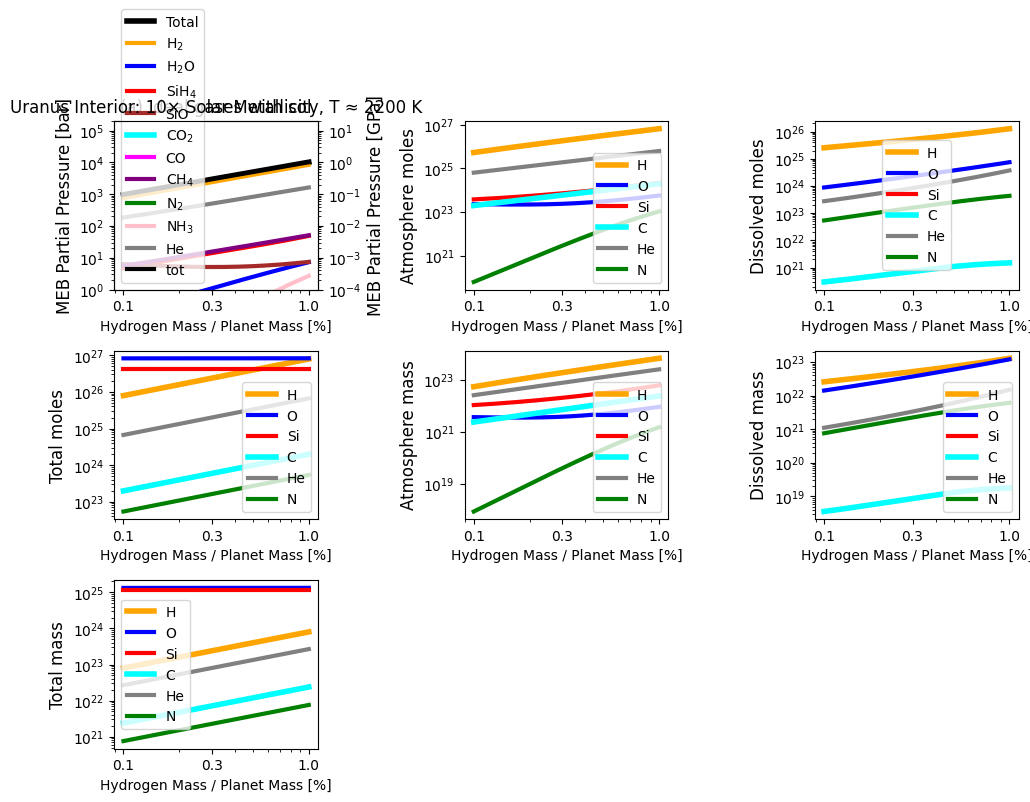

[20:16:49 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:16:49 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:16:49 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:16:49 - atmodeller.classes             - IN

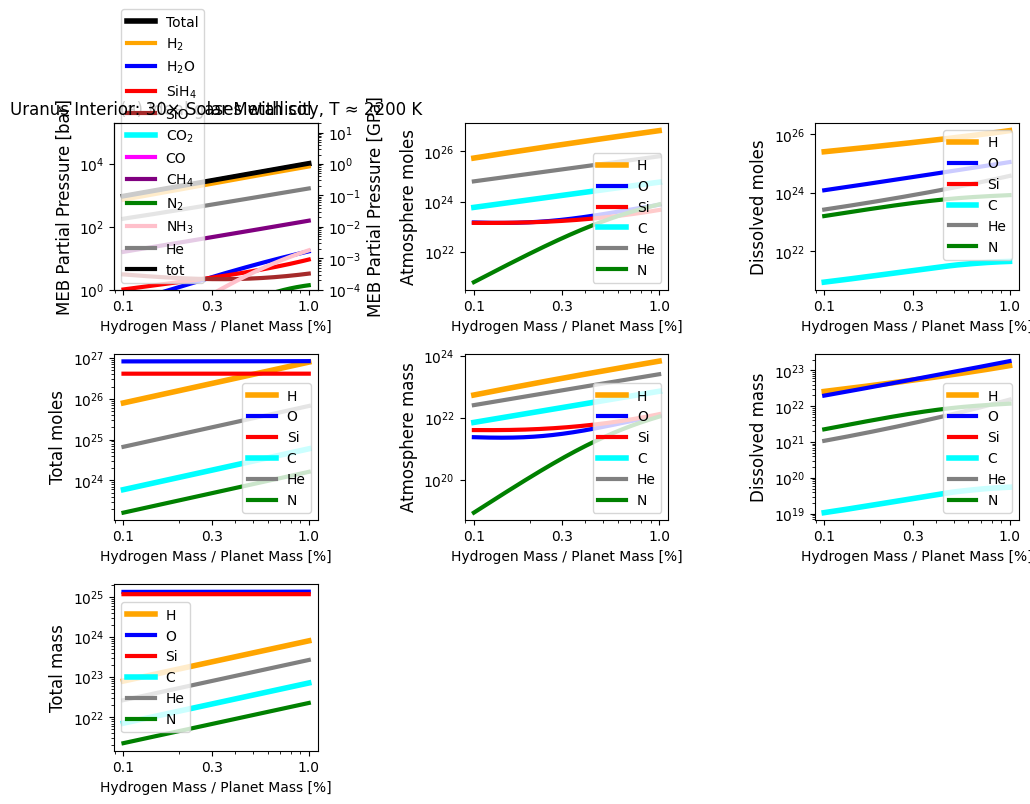

[20:17:25 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:17:25 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:17:25 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:17:25 - atmodeller.classes             - IN

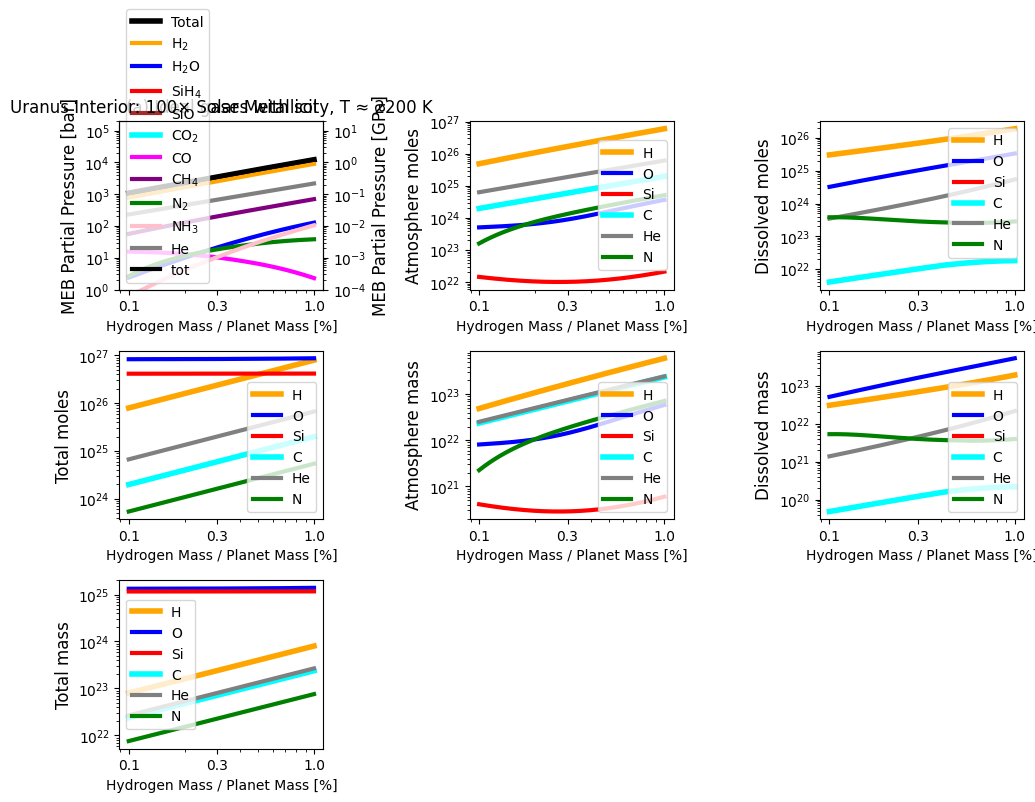

[20:18:00 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:18:00 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:18:00 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:18:00 - atmodeller.classes             - IN

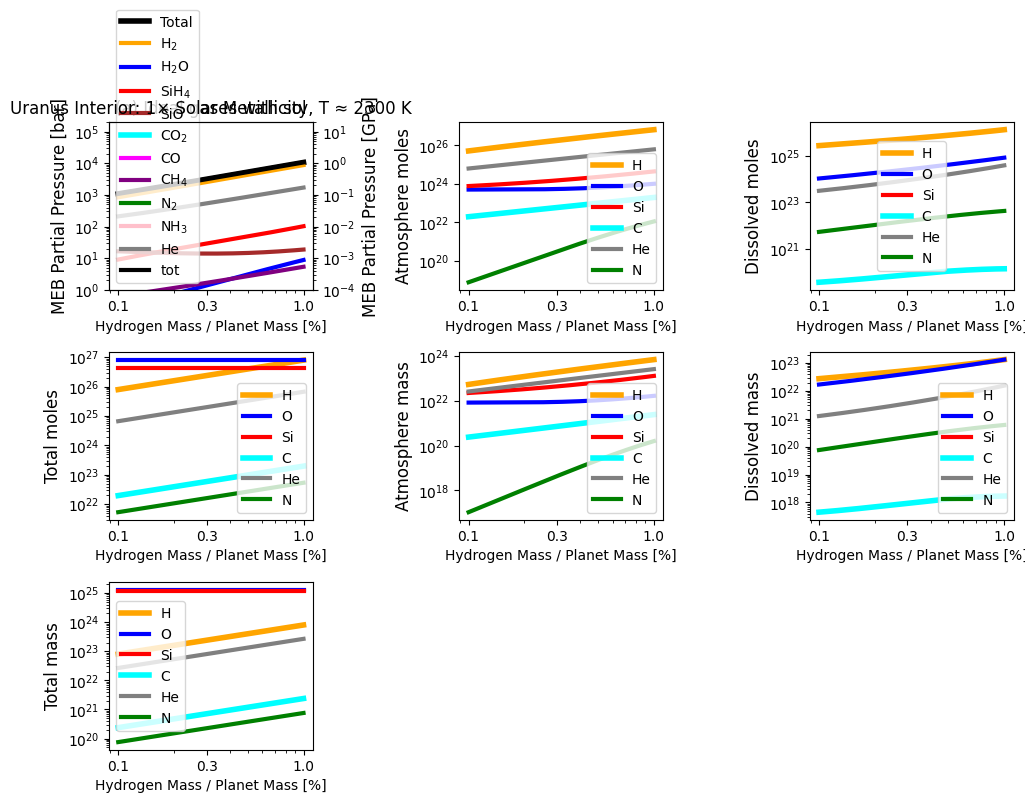

[20:18:34 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:18:34 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:18:34 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:18:34 - atmodeller.classes             - IN

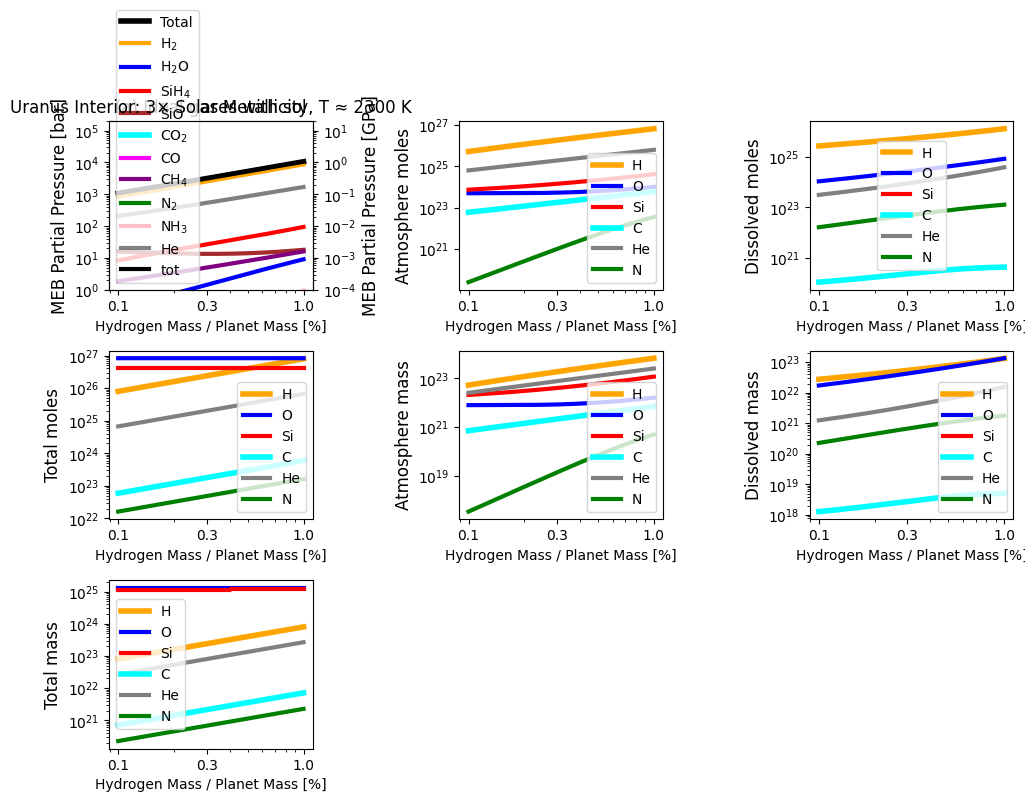

[20:19:11 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:19:11 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:19:11 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:19:11 - atmodeller.classes             - IN

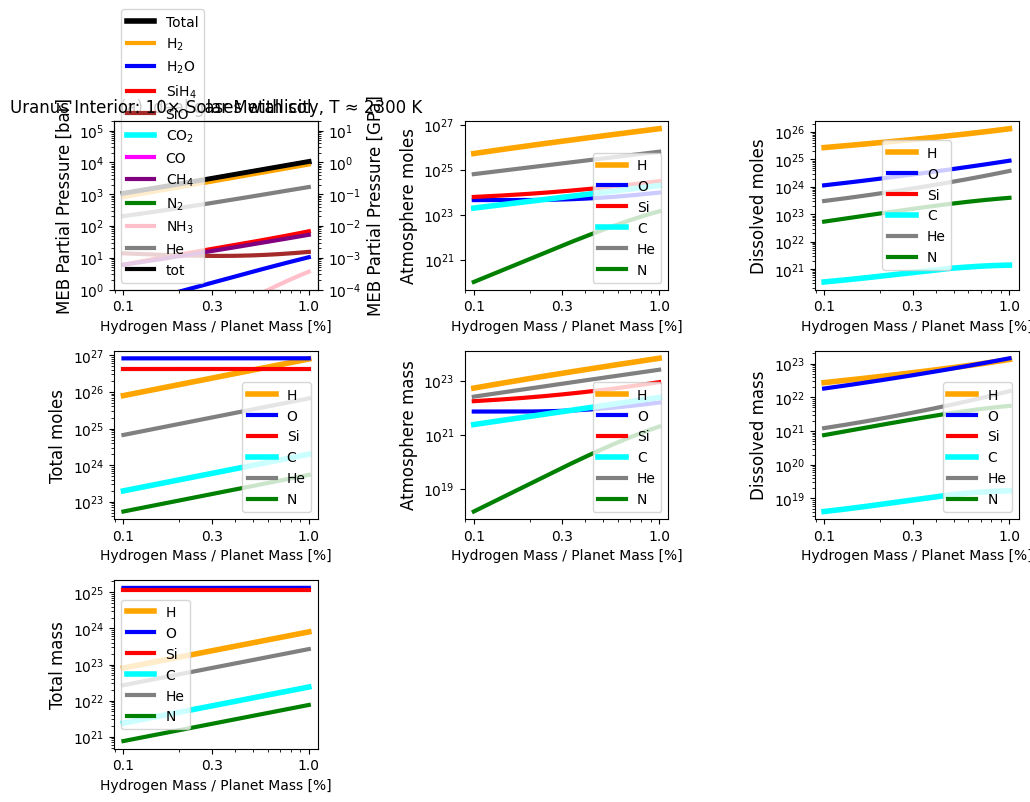

[20:19:46 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:19:46 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:19:46 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:19:46 - atmodeller.classes             - IN

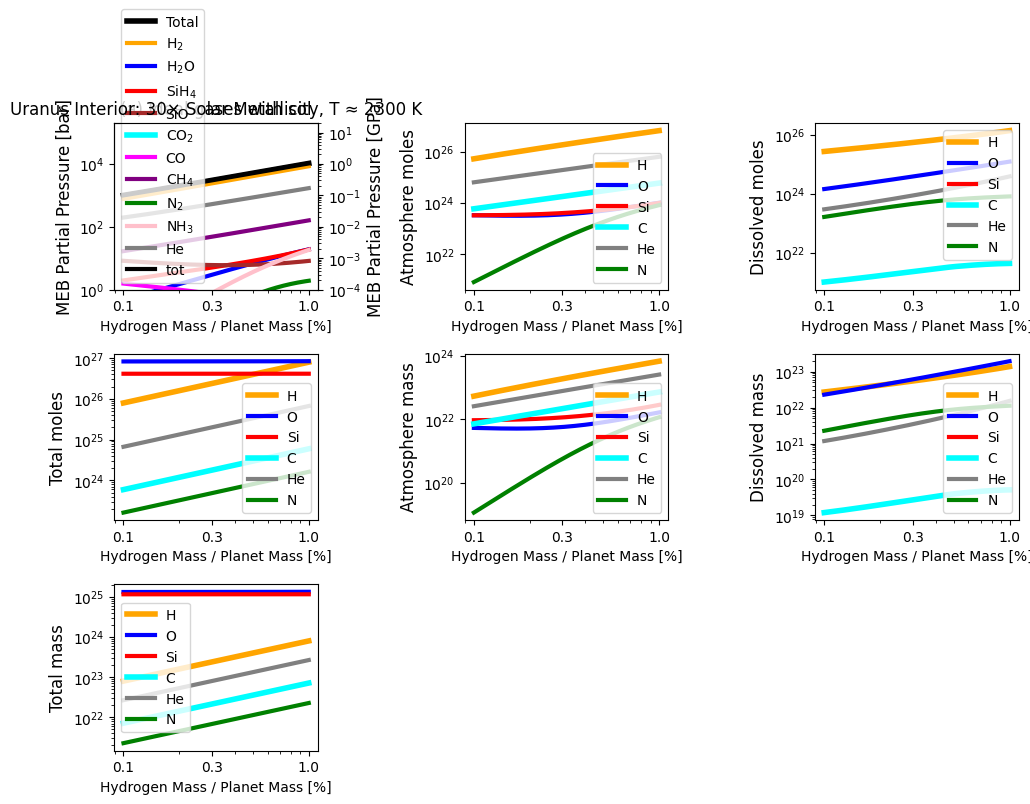

[20:20:20 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:20:20 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:20:20 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:20:20 - atmodeller.classes             - IN

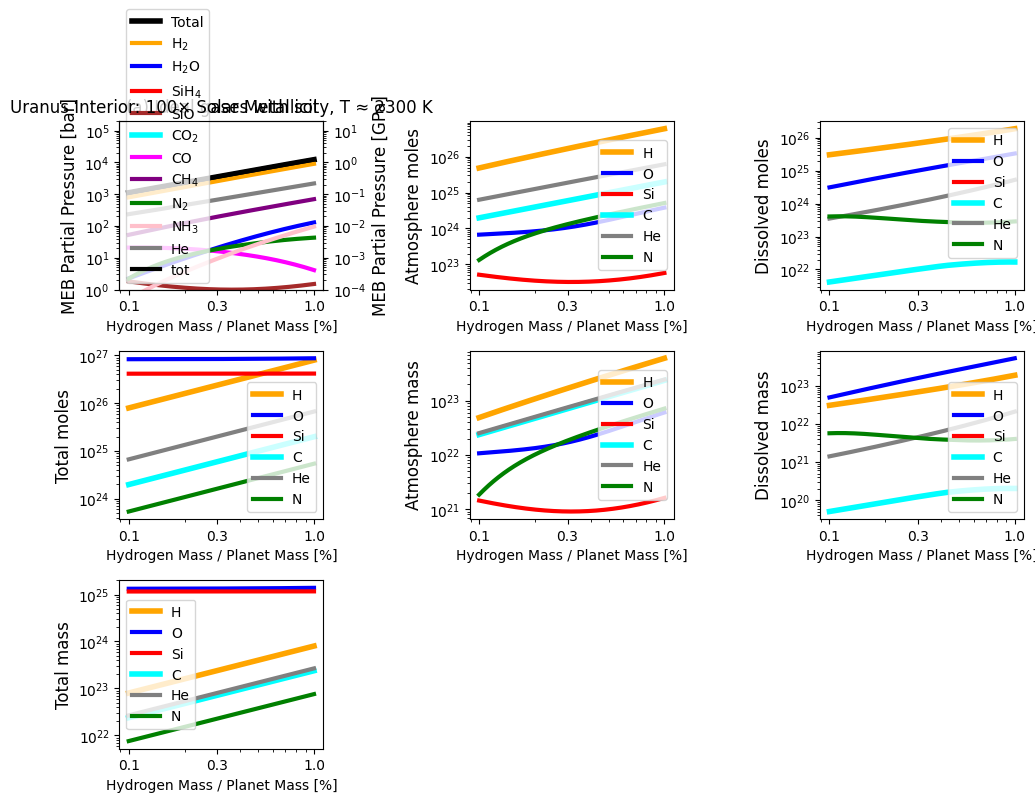

[20:20:51 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:20:51 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:20:51 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:20:51 - atmodeller.classes             - IN

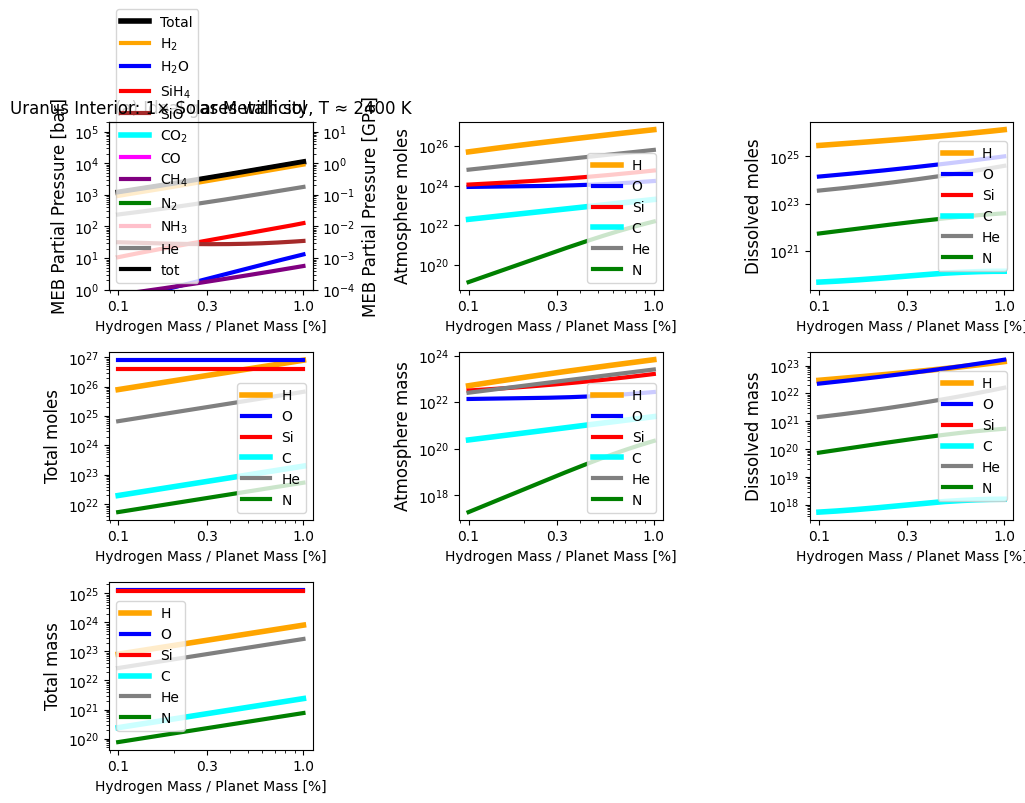

[20:21:23 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:21:23 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:21:23 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:21:23 - atmodeller.classes             - IN

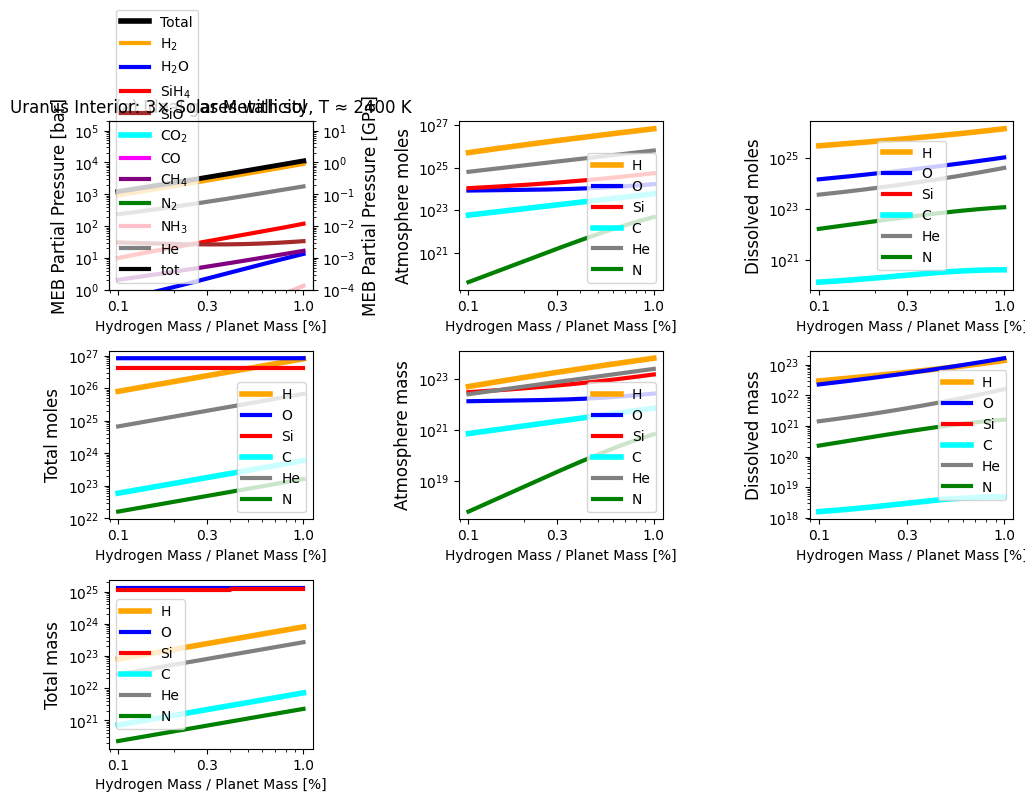

[20:21:56 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:21:56 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:21:56 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:21:56 - atmodeller.classes             - IN

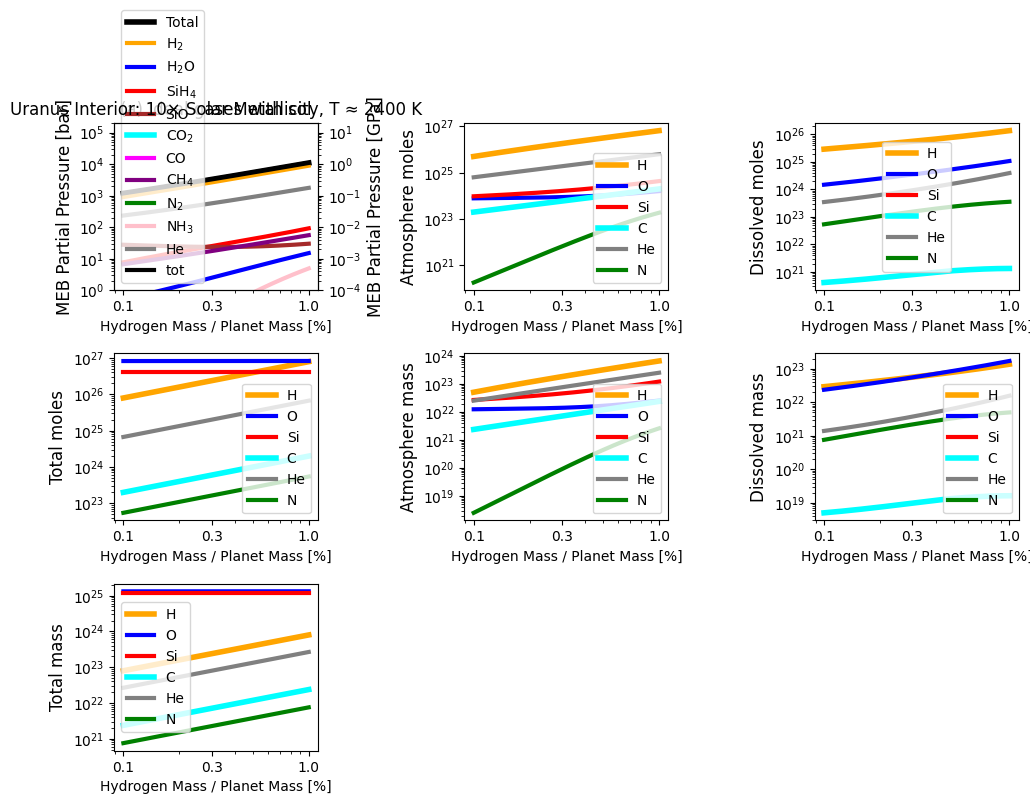

[20:22:29 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:22:29 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:22:29 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:22:29 - atmodeller.classes             - IN

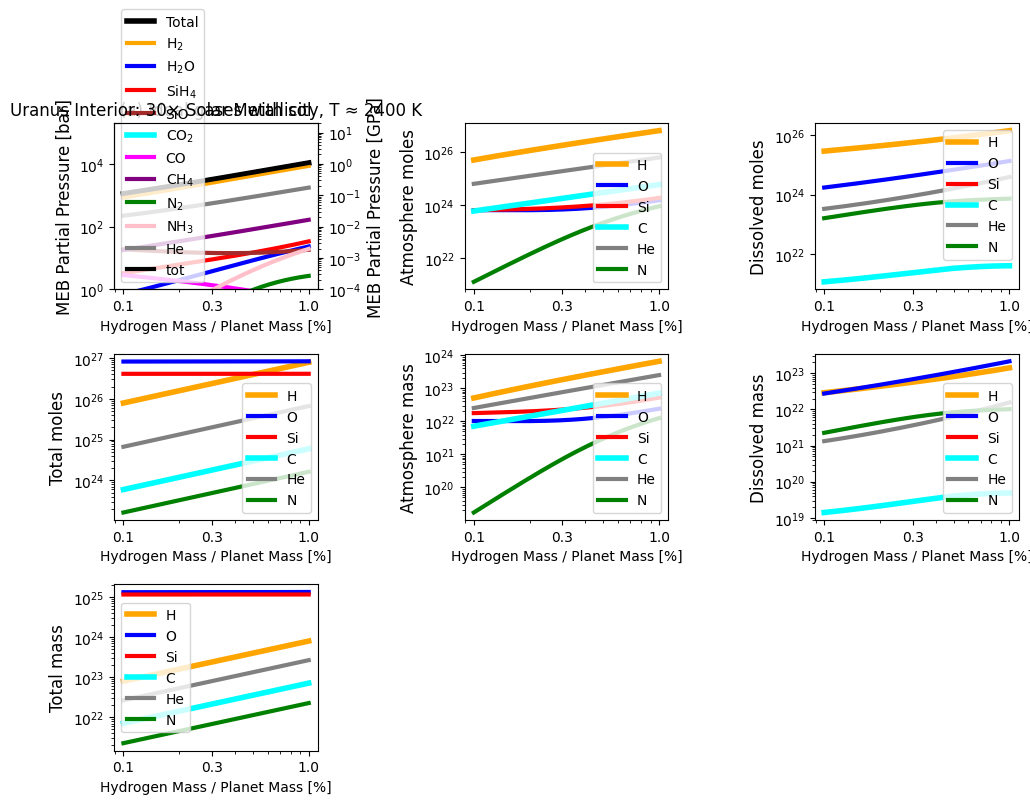

[20:23:02 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:23:02 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:23:02 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:23:02 - atmodeller.classes             - IN

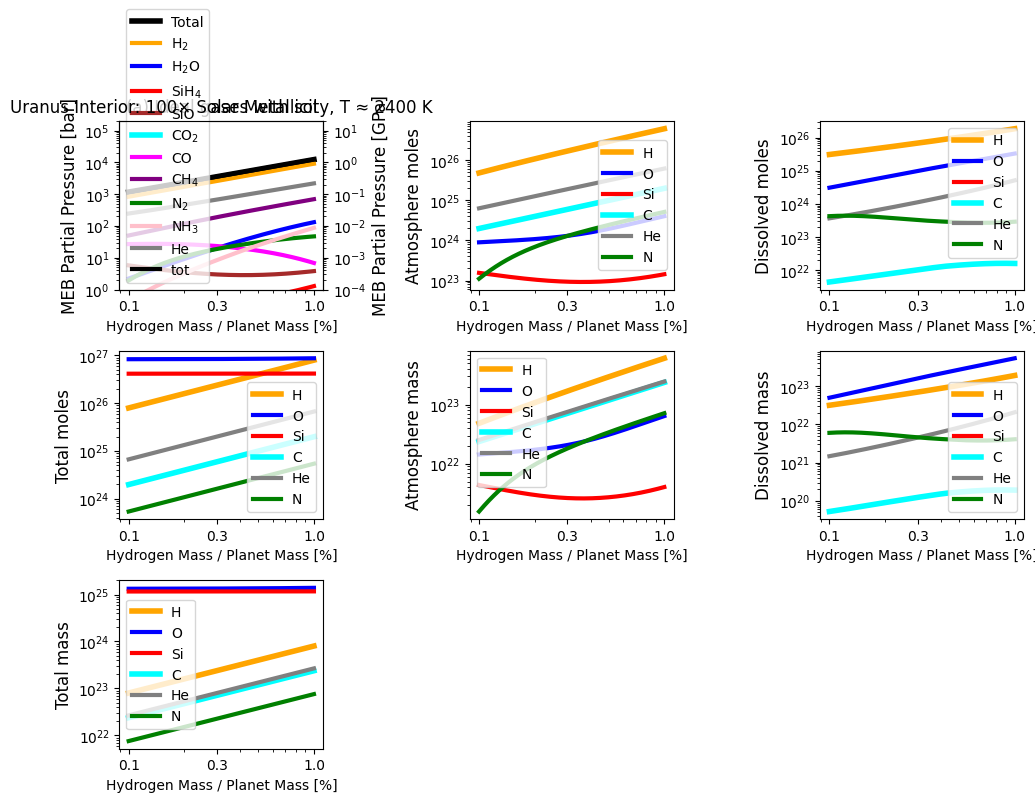

[20:23:35 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:23:35 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:23:35 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:23:35 - atmodeller.classes             - IN

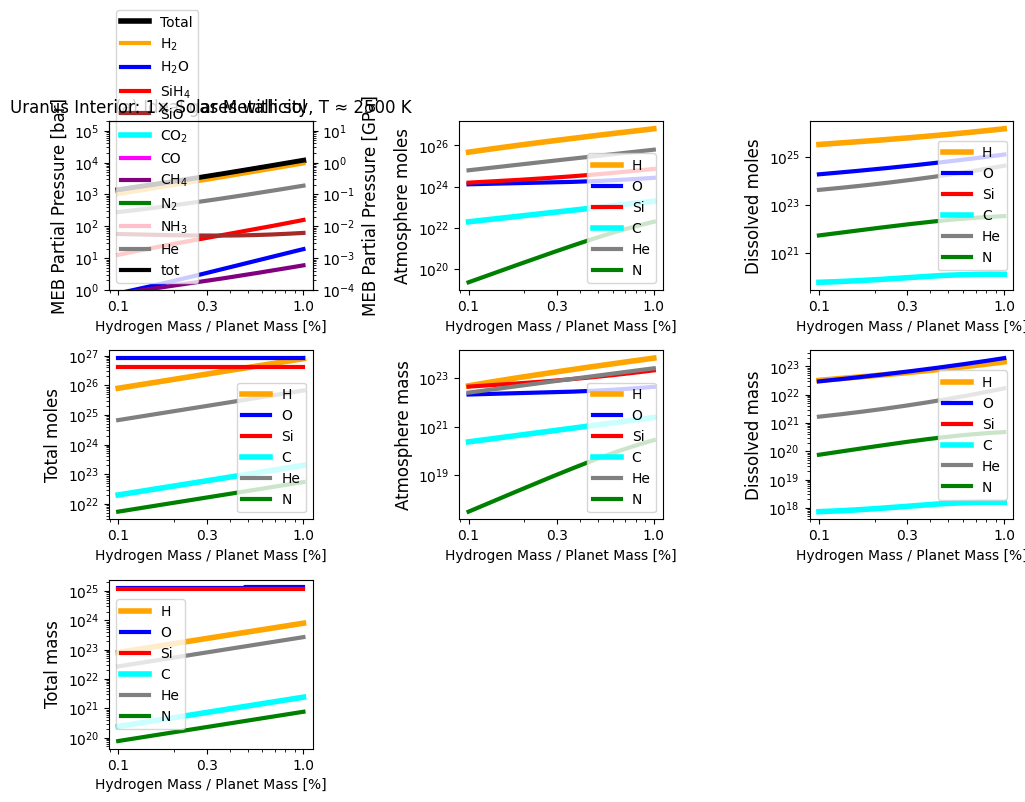

[20:24:08 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:24:08 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:24:08 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:24:08 - atmodeller.classes             - IN

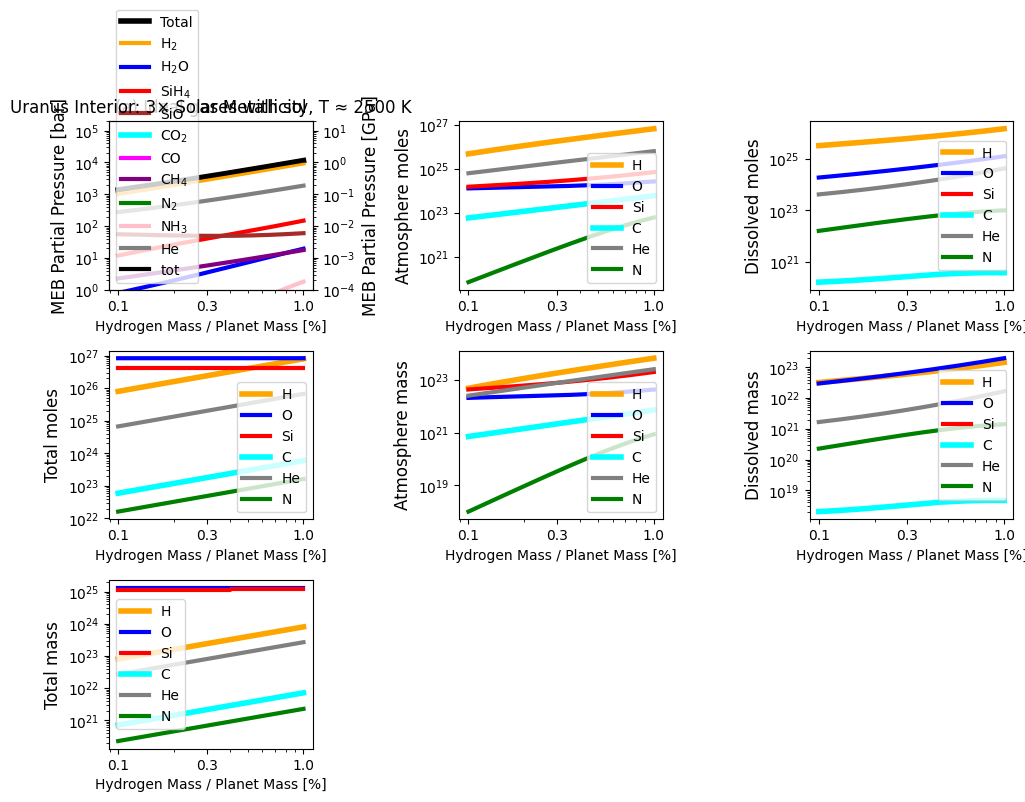

[20:24:41 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:24:41 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:24:41 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:24:41 - atmodeller.classes             - IN

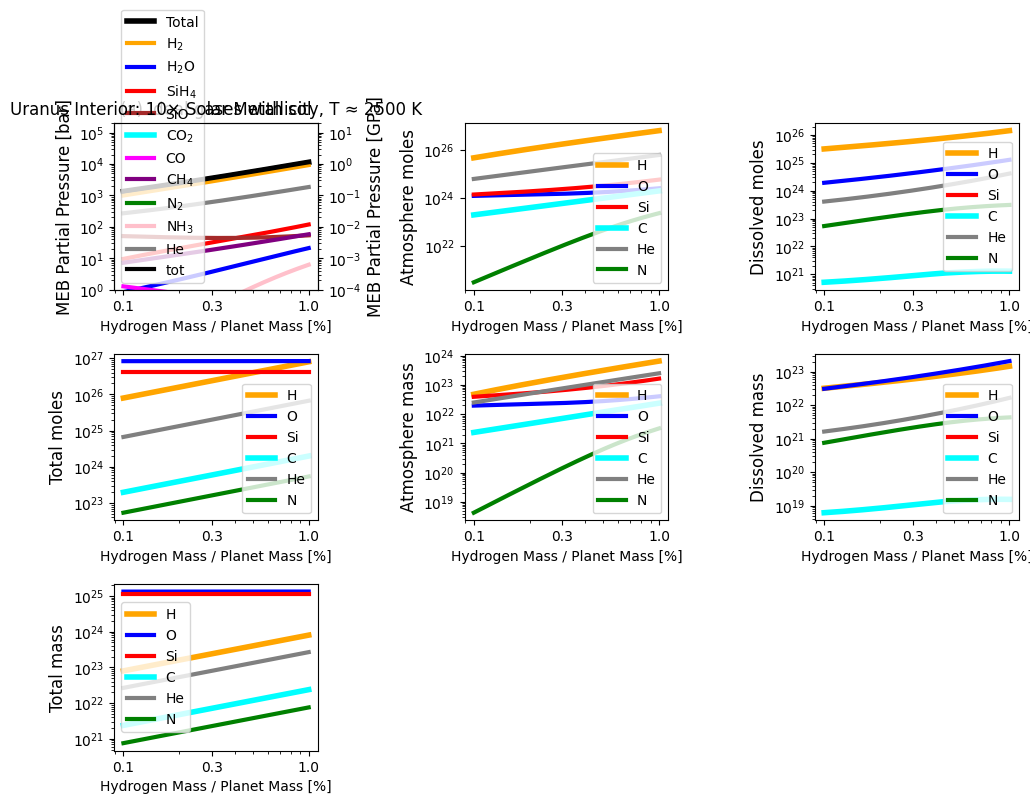

[20:25:23 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:25:23 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:25:23 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:25:23 - atmodeller.classes             - IN

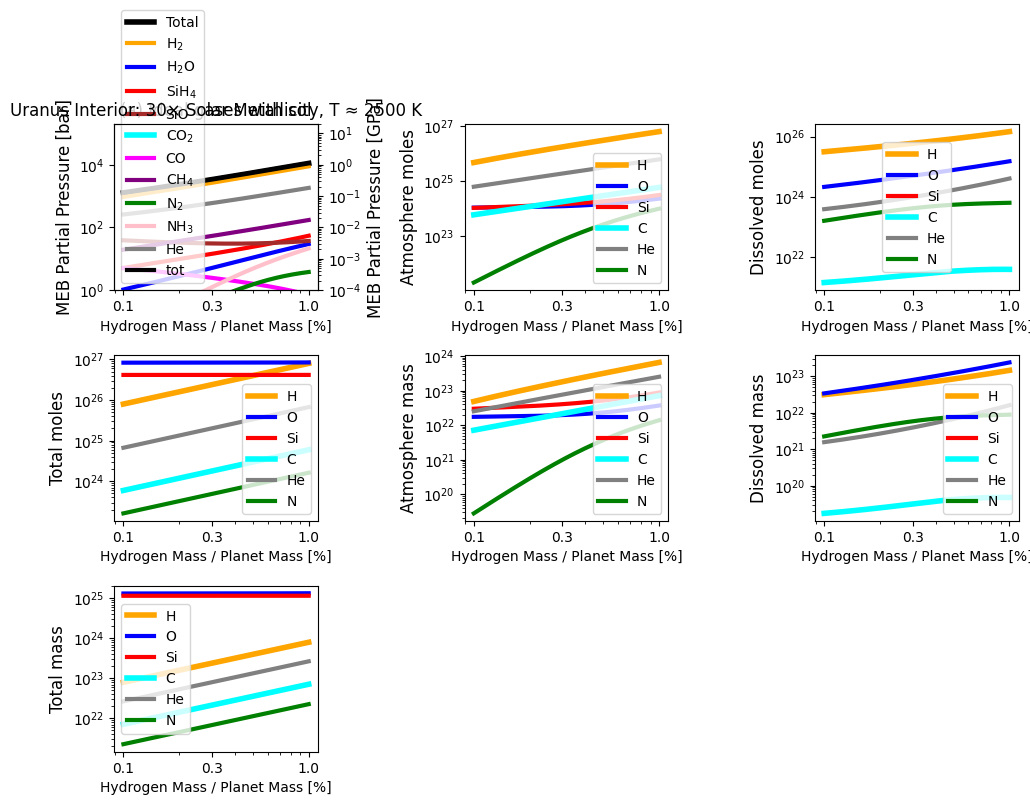

[20:26:01 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:26:01 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:26:01 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:26:01 - atmodeller.classes             - IN

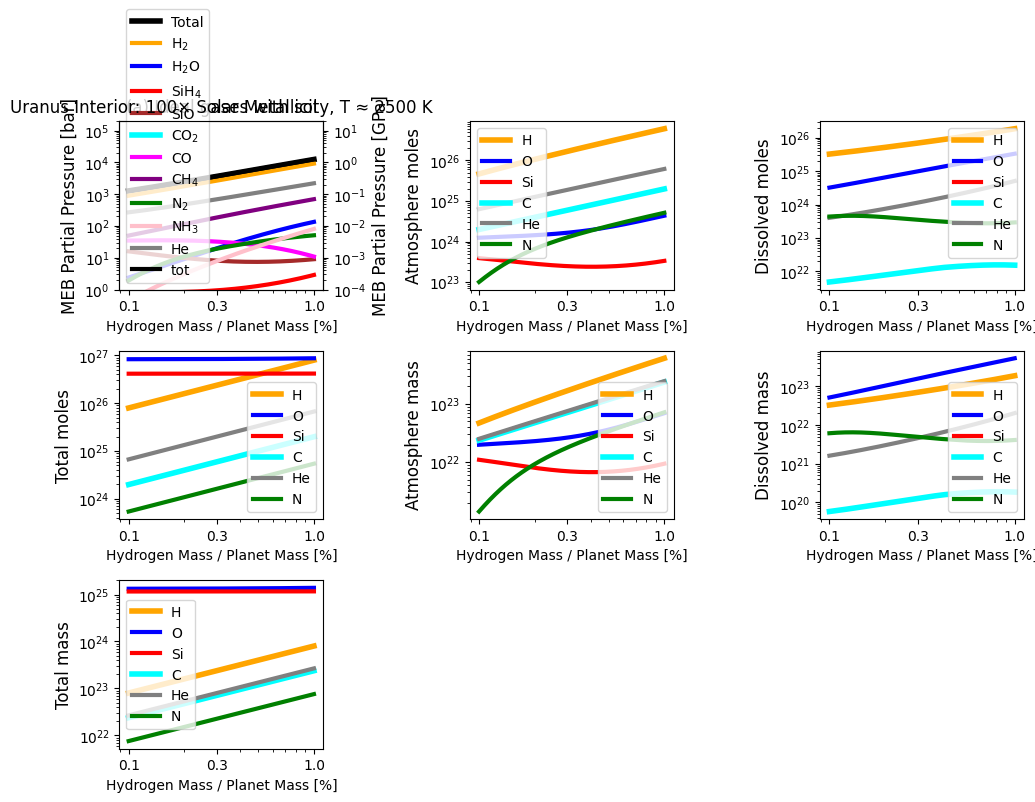

[20:26:36 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:26:36 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:26:36 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:26:36 - atmodeller.classes             - IN

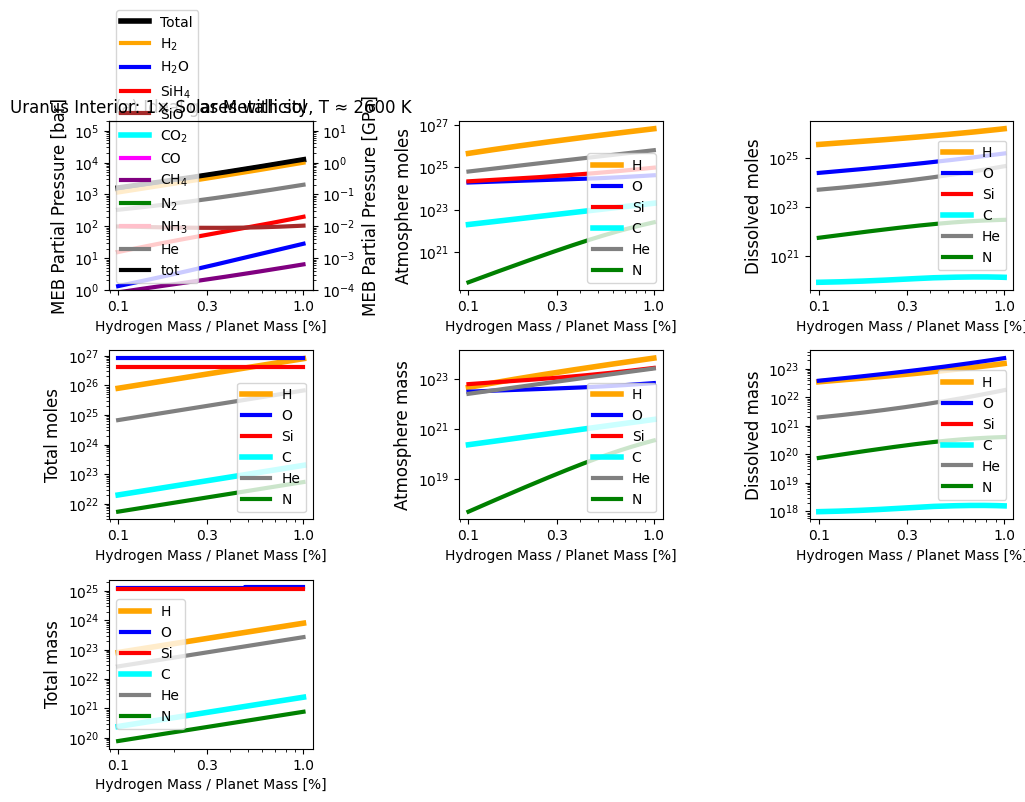

[20:27:13 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:27:13 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:27:13 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:27:13 - atmodeller.classes             - IN

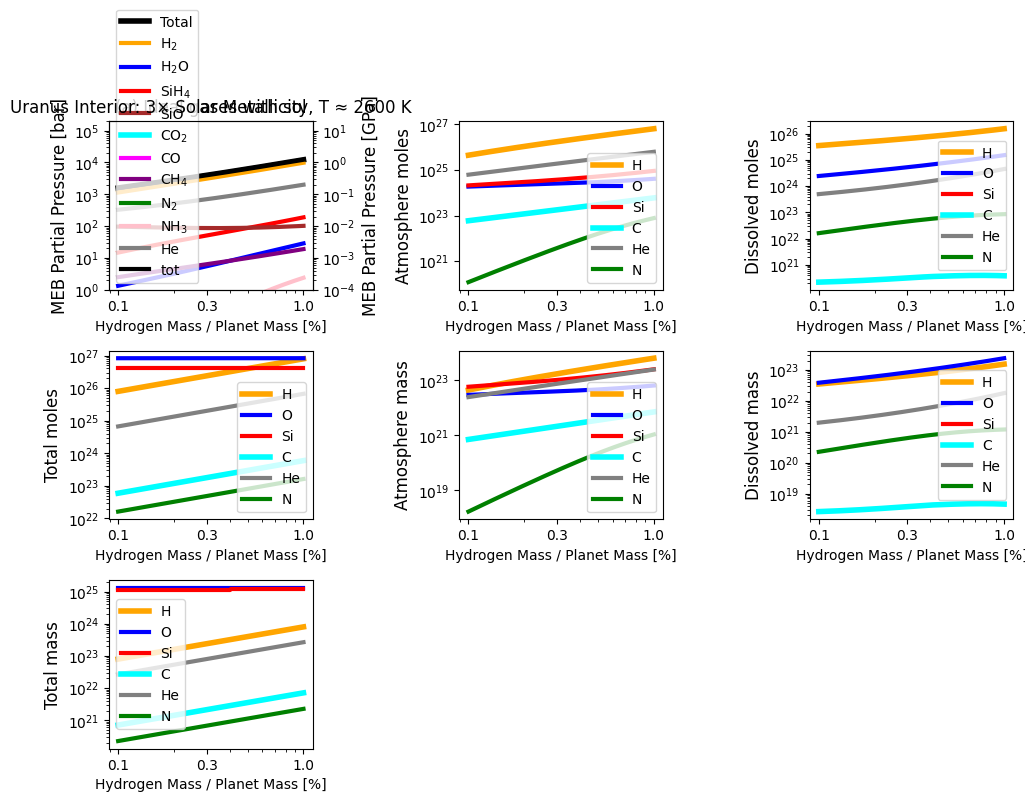

[20:27:50 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:27:50 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:27:50 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:27:51 - atmodeller.classes             - IN

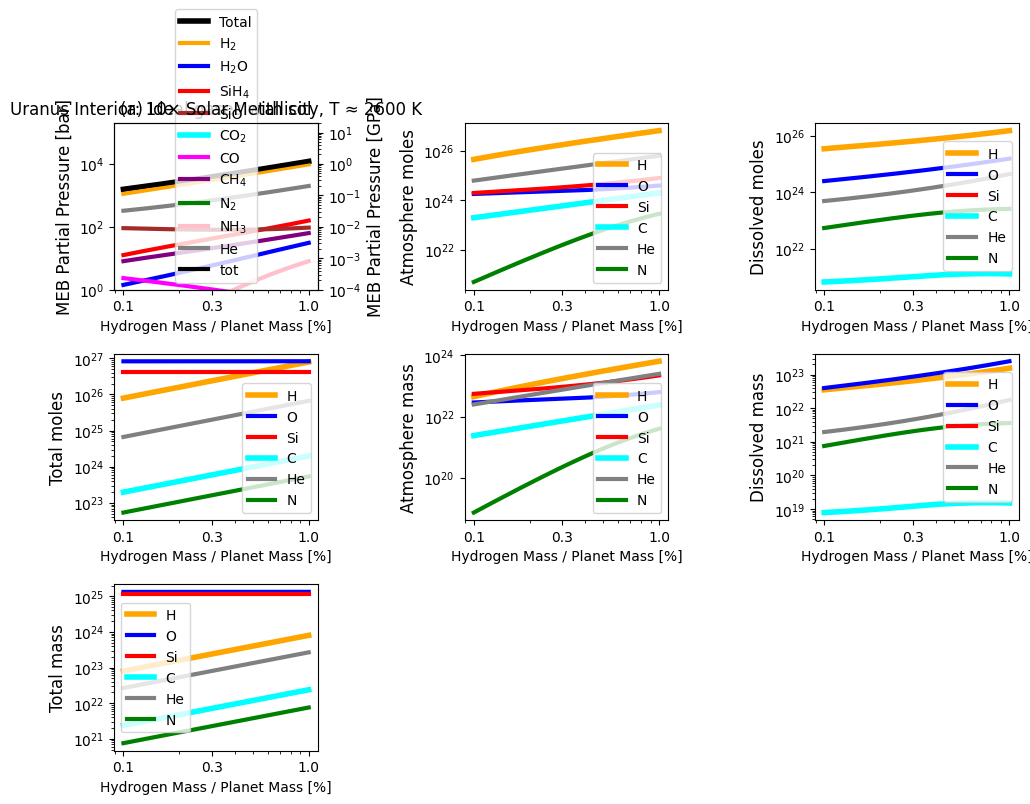

[20:28:29 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:28:29 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:28:29 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:28:29 - atmodeller.classes             - IN

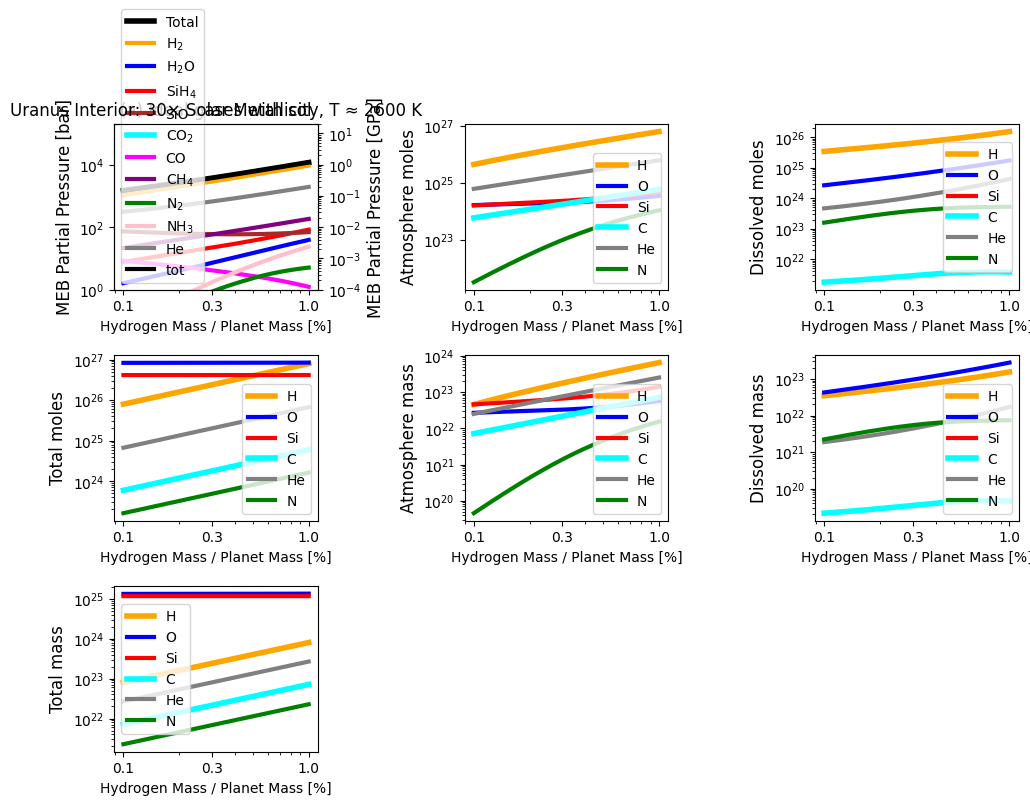

[20:29:11 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:29:11 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:29:11 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:29:11 - atmodeller.classes             - IN

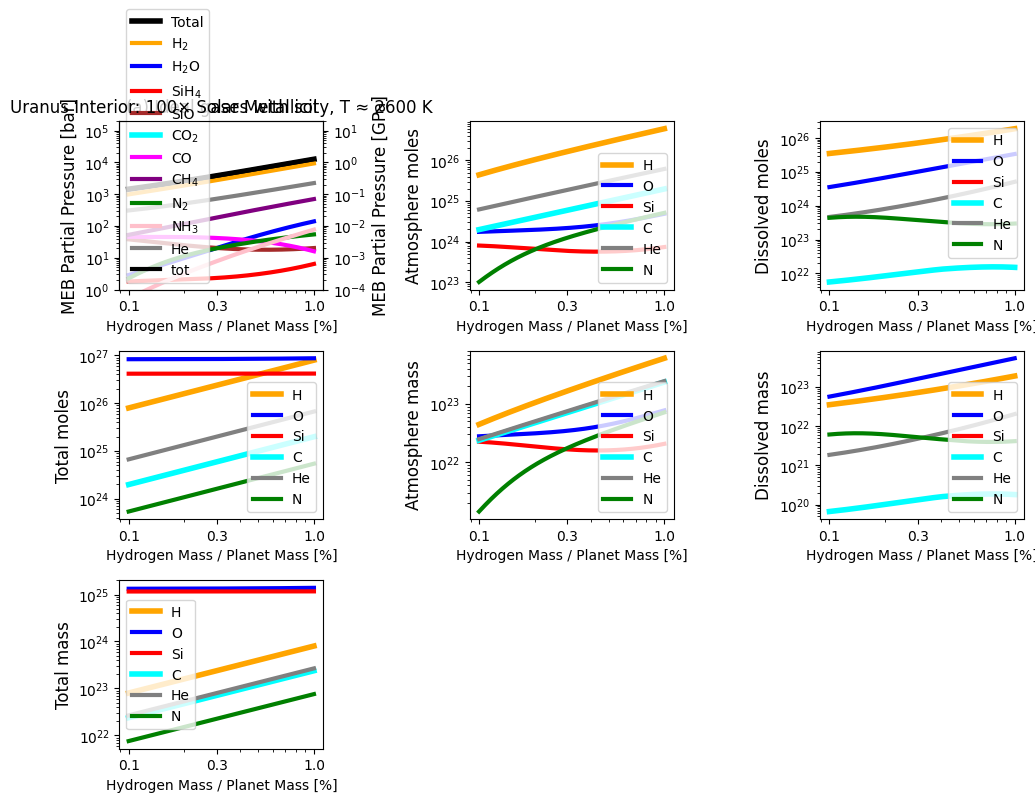

[20:29:47 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:29:47 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:29:47 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:29:47 - atmodeller.classes             - IN

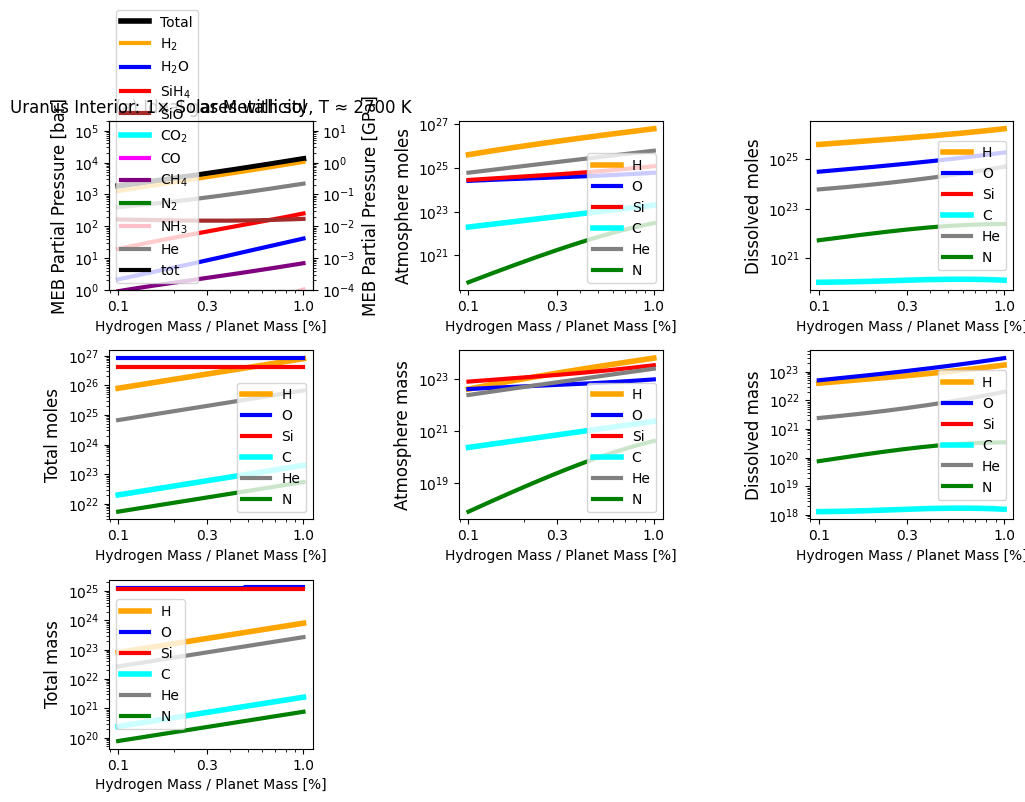

[20:30:23 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:30:23 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:30:23 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:30:23 - atmodeller.classes             - IN

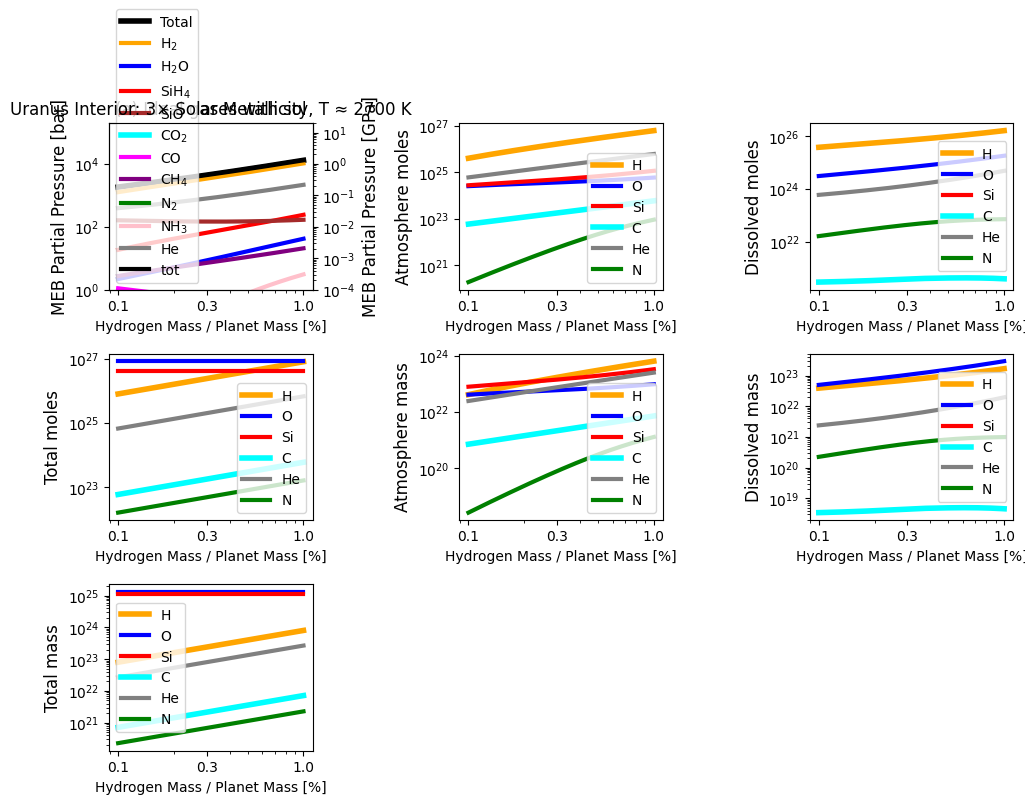

[20:31:01 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:31:01 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:31:01 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:31:01 - atmodeller.classes             - IN

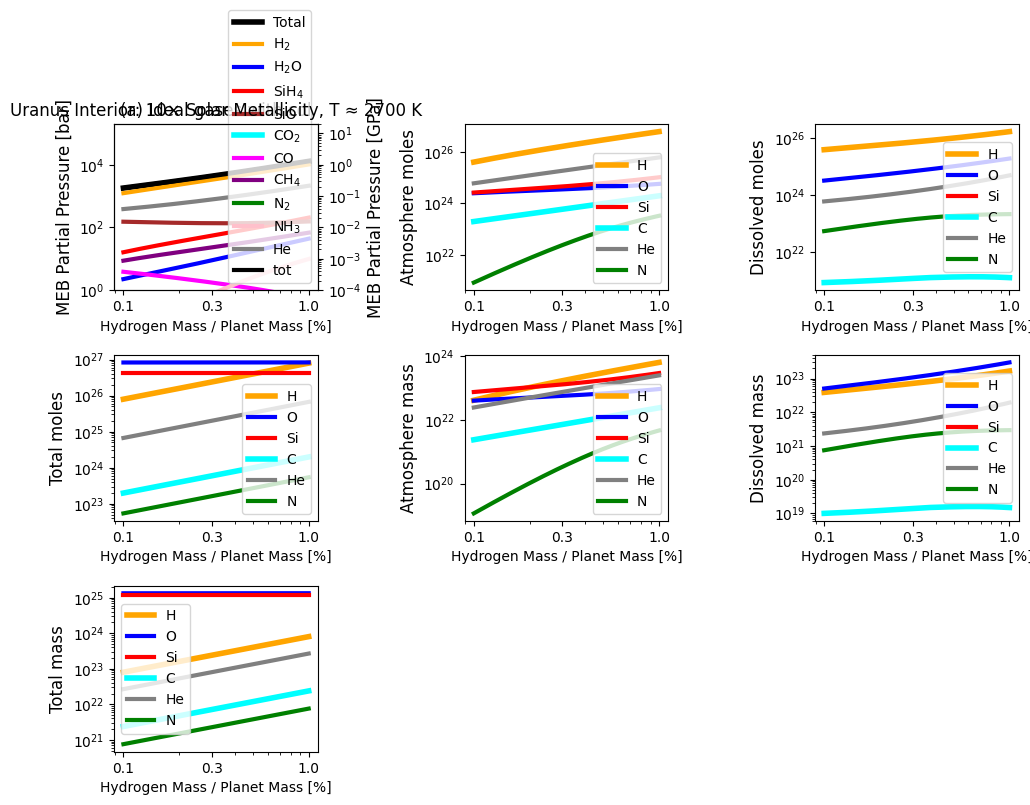

[20:31:37 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:31:37 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:31:37 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:31:37 - atmodeller.classes             - IN

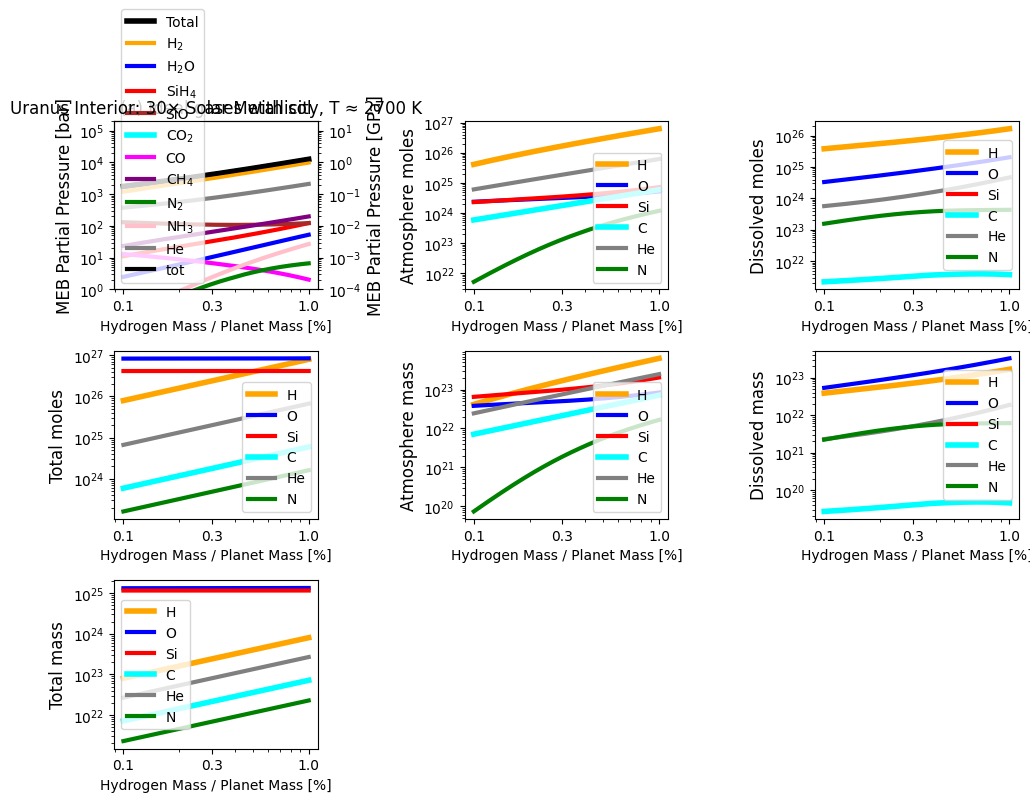

[20:32:14 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:32:14 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:32:14 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:32:14 - atmodeller.classes             - IN

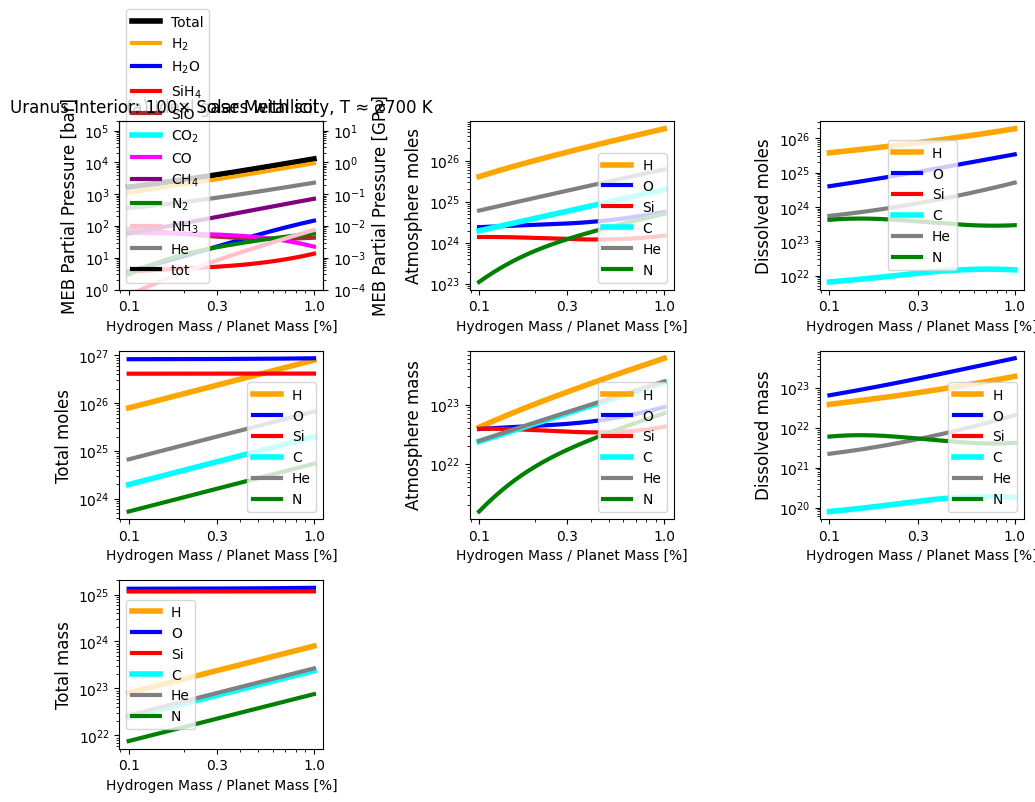

[20:32:50 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:32:50 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:32:50 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:32:50 - atmodeller.classes             - IN

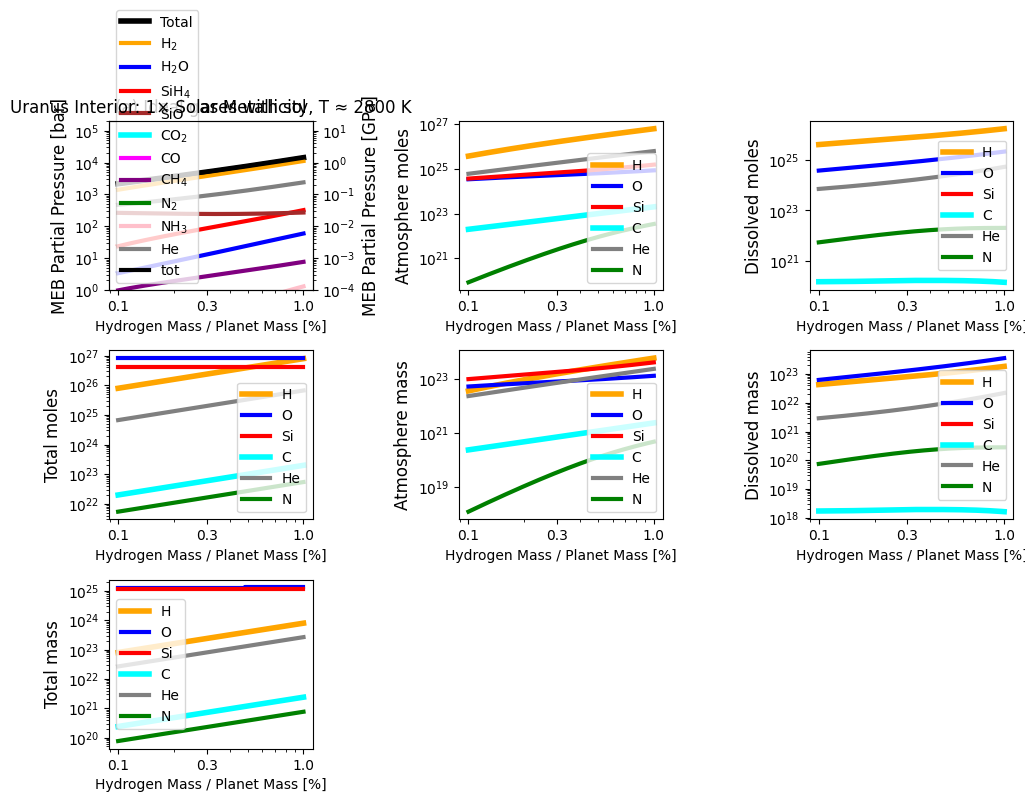

[20:33:24 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:33:24 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:33:24 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:33:24 - atmodeller.classes             - IN

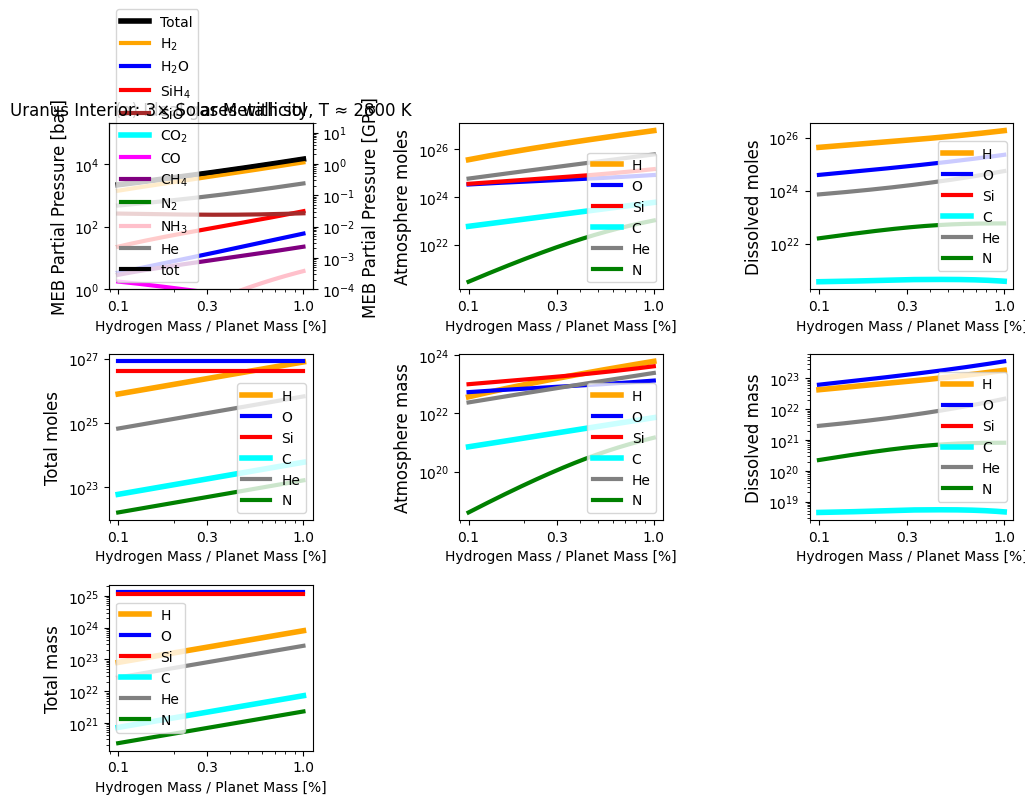

[20:33:58 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:33:58 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:33:58 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:33:59 - atmodeller.classes             - IN

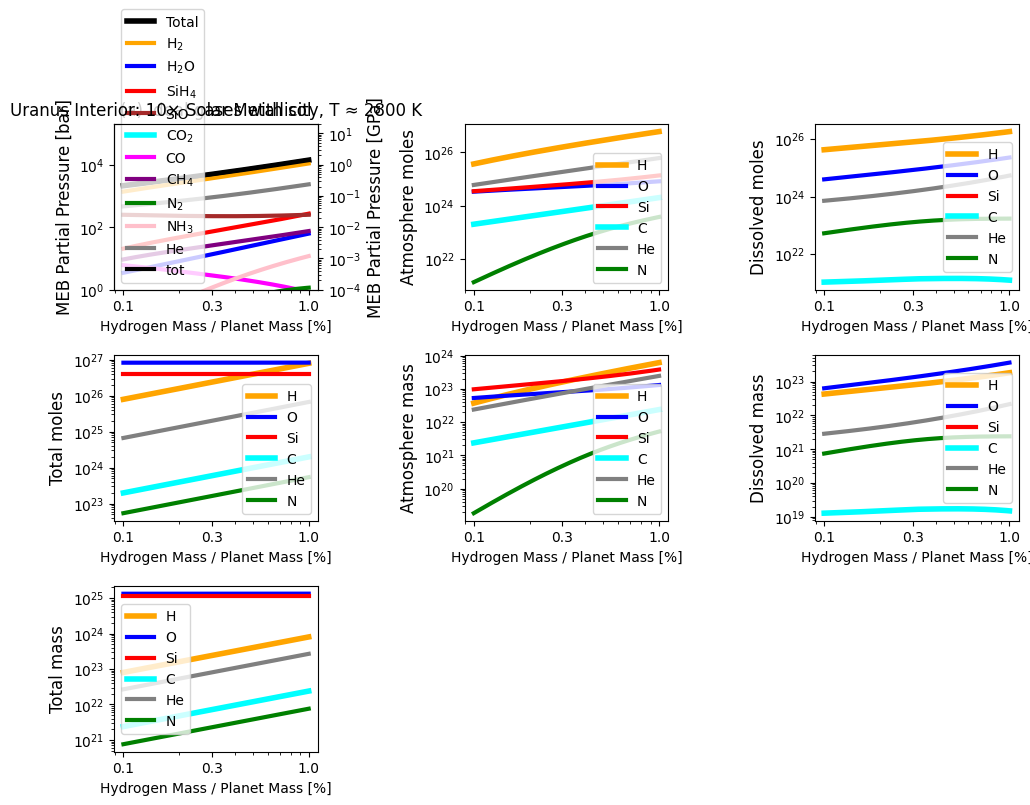

[20:34:32 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:34:32 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:34:32 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:34:32 - atmodeller.classes             - IN

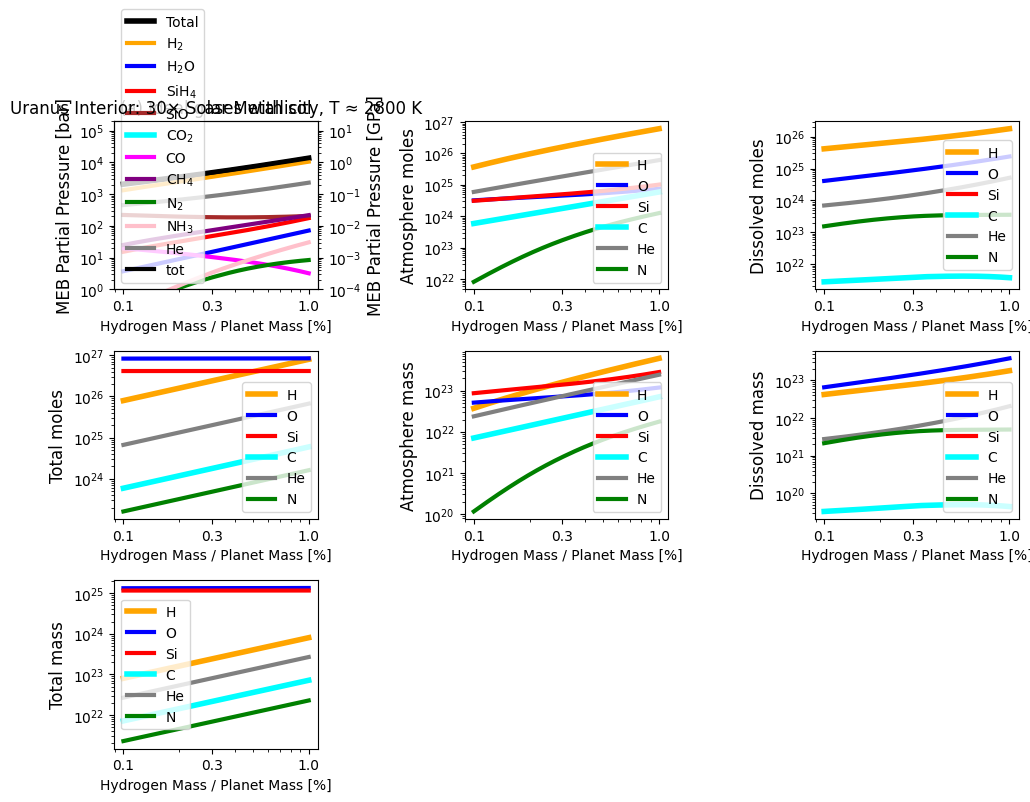

[20:35:06 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:35:06 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:35:06 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:35:06 - atmodeller.classes             - IN

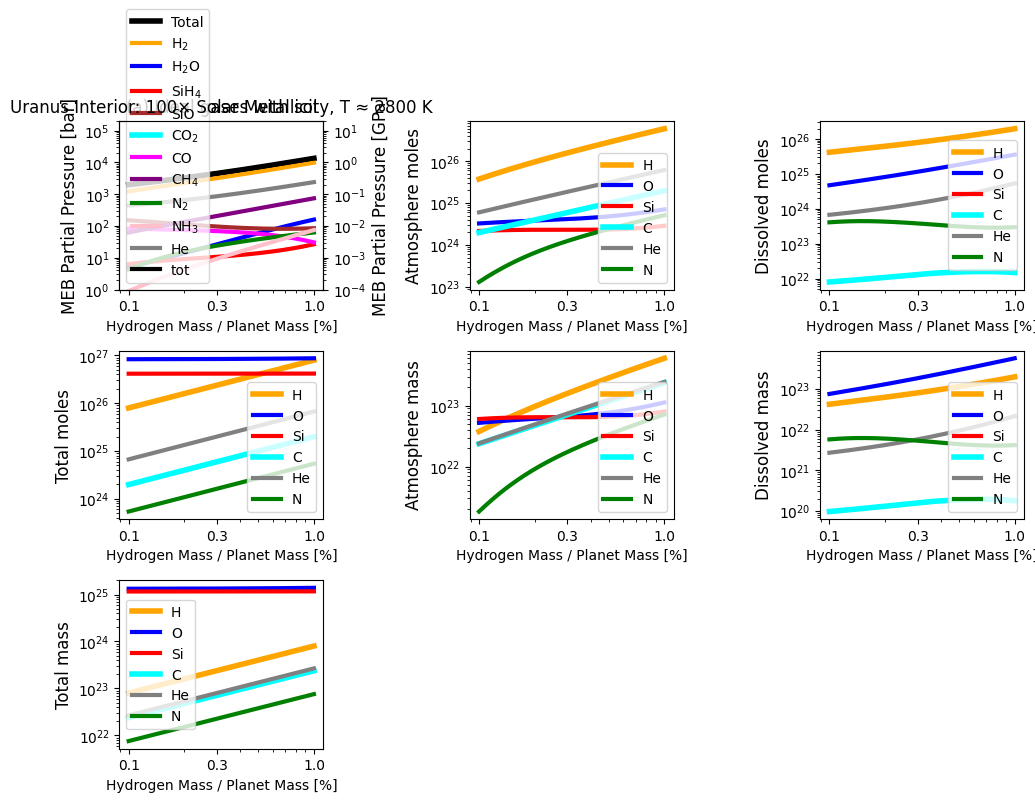

[20:35:41 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:35:41 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:35:41 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:35:41 - atmodeller.classes             - IN

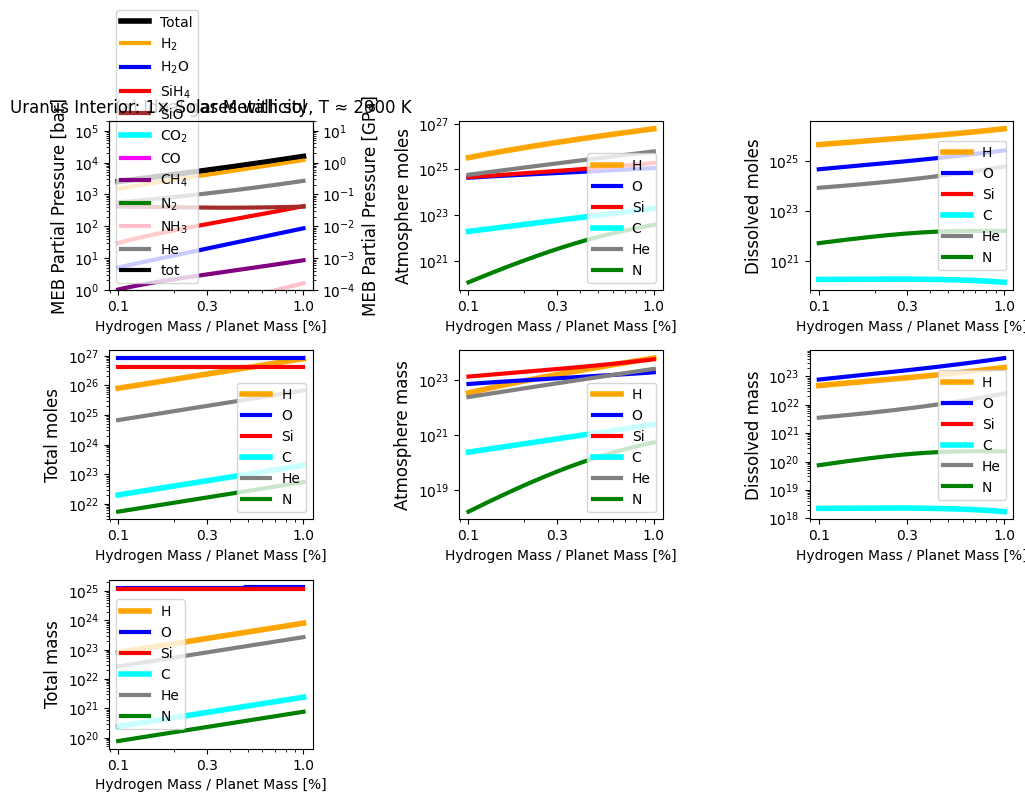

[20:36:14 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:36:14 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:36:14 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:36:14 - atmodeller.classes             - IN

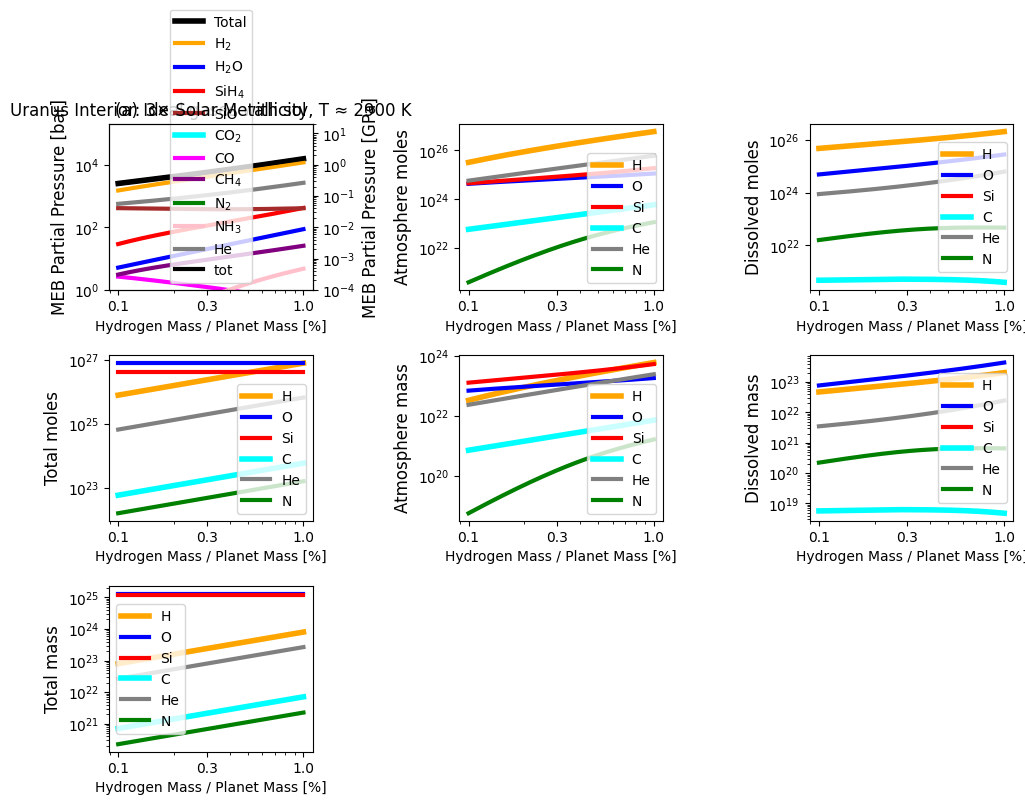

[20:36:46 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:36:46 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:36:46 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:36:46 - atmodeller.classes             - IN

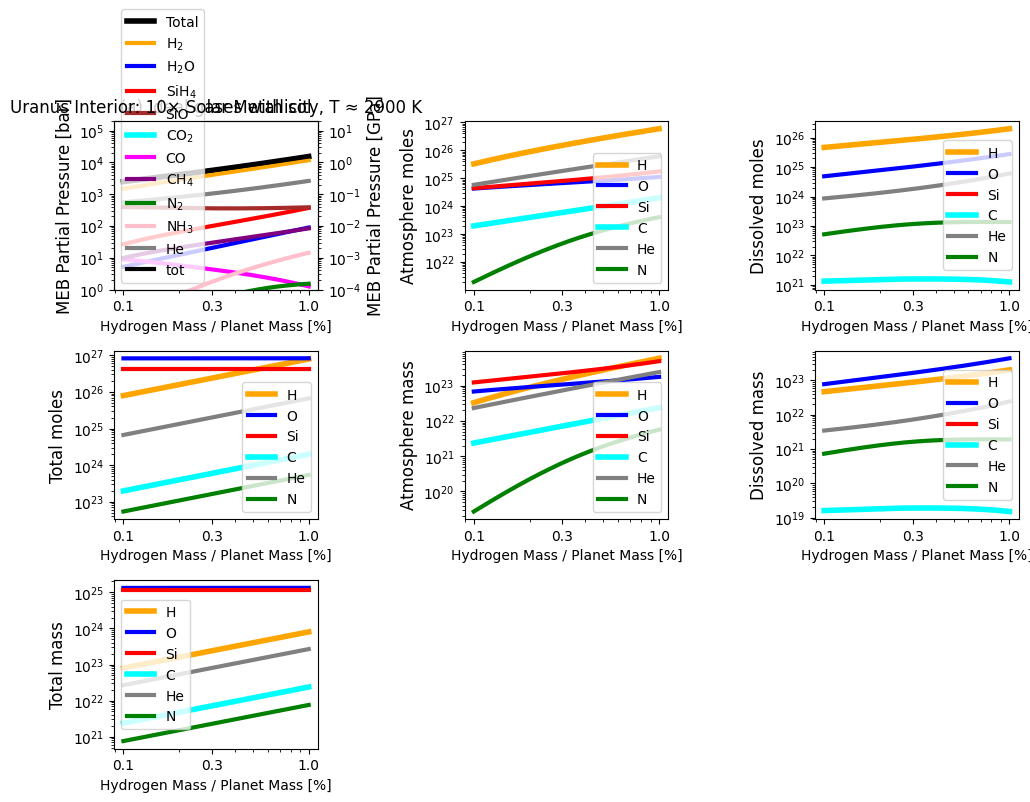

[20:37:18 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:37:18 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:37:18 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:37:18 - atmodeller.classes             - IN

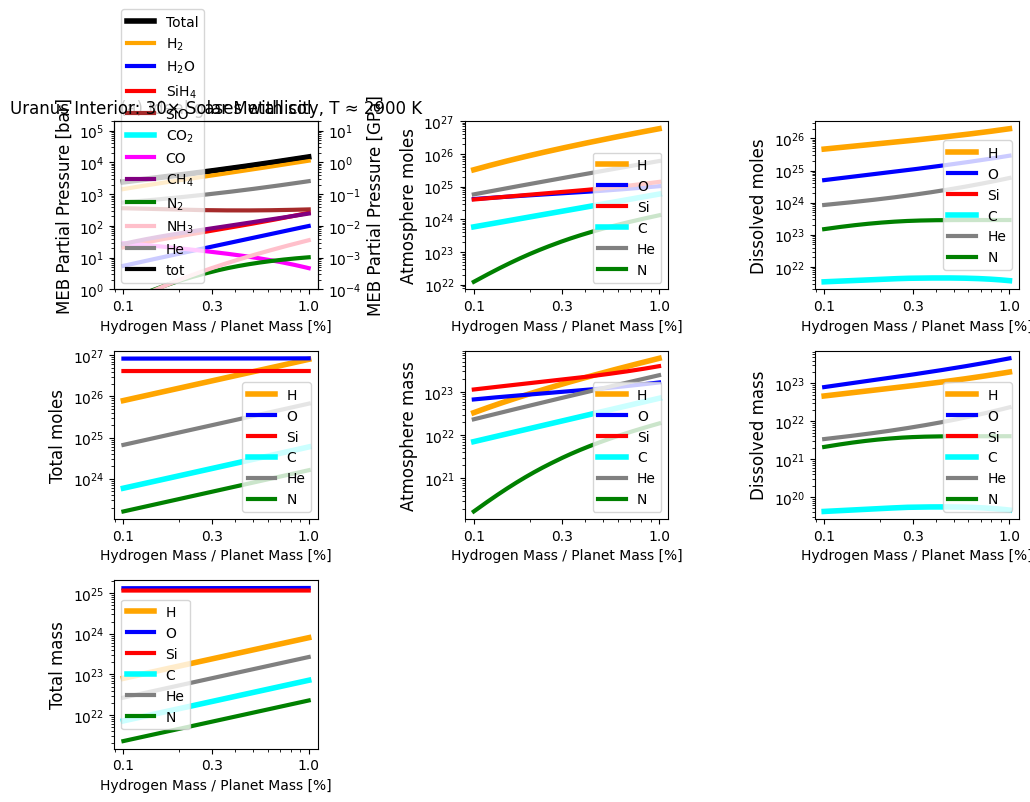

[20:37:51 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:37:51 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:37:51 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:37:51 - atmodeller.classes             - IN

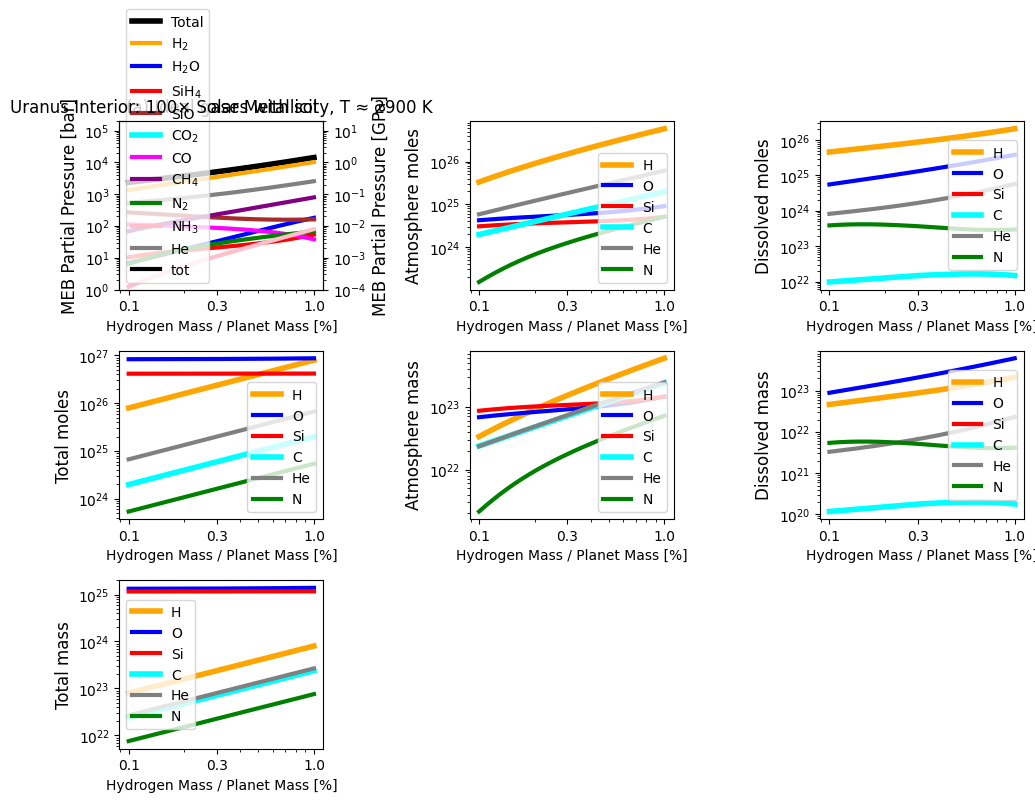

[20:38:23 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:38:23 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:38:23 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:38:23 - atmodeller.classes             - IN

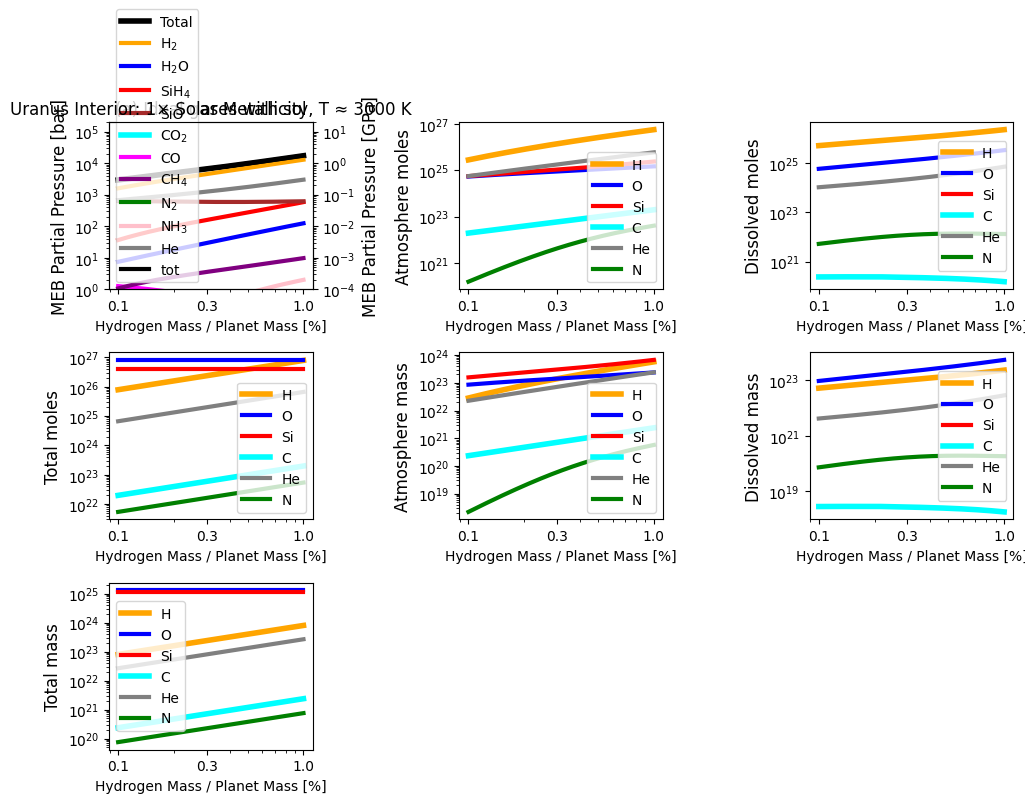

[20:38:55 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:38:55 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:38:55 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:38:55 - atmodeller.classes             - IN

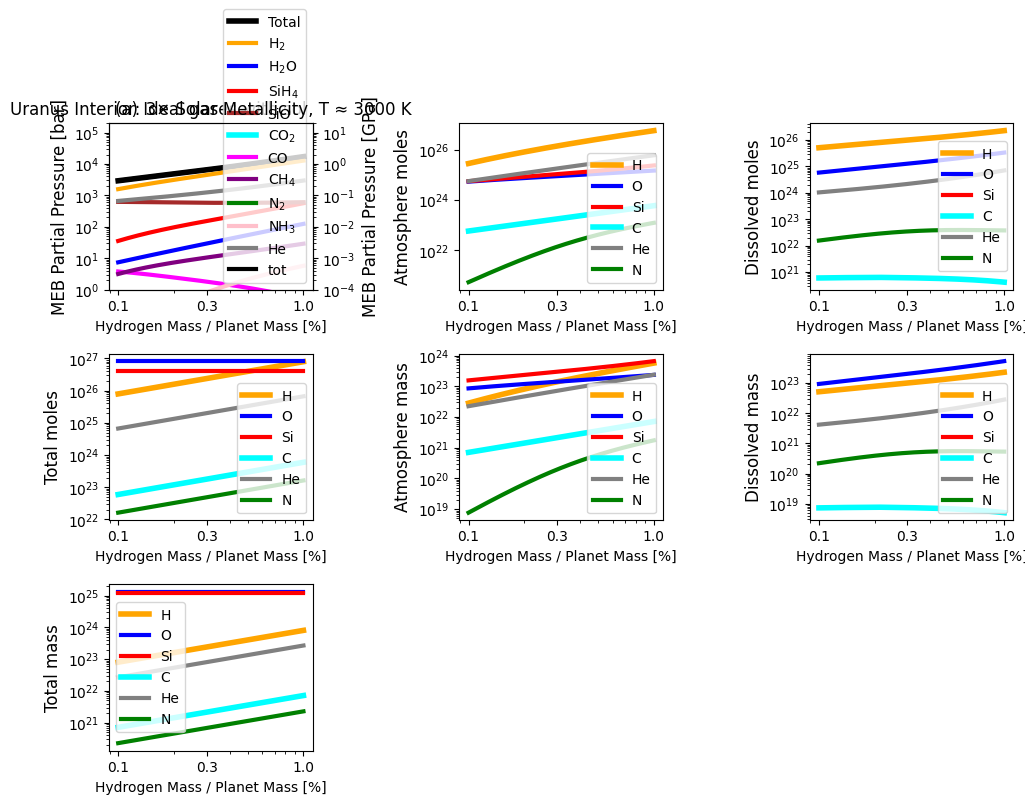

[20:39:30 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:39:30 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:39:30 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:39:30 - atmodeller.classes             - IN

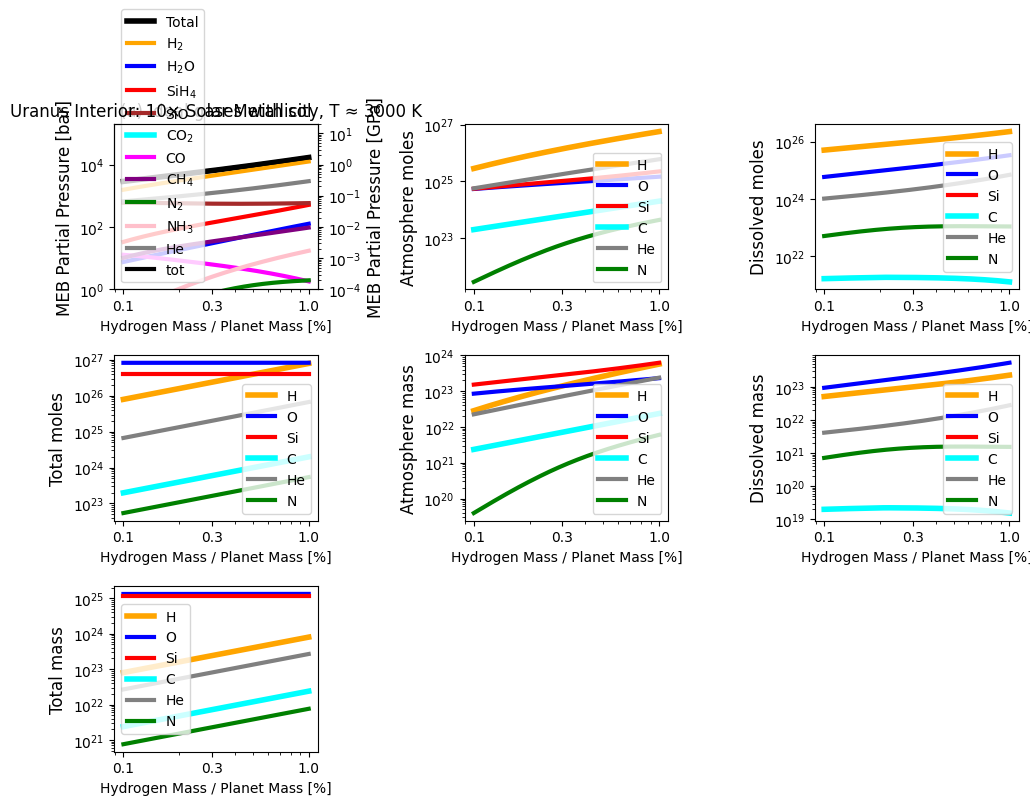

[20:40:08 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:40:08 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:40:08 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:40:08 - atmodeller.classes             - IN

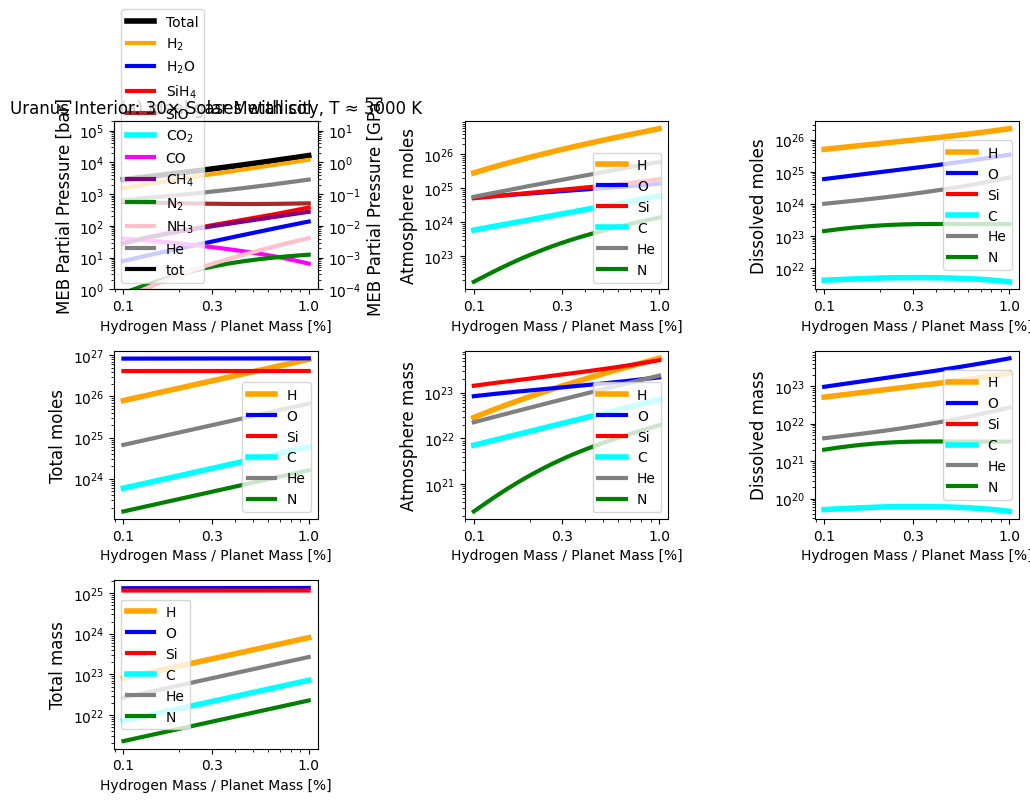

[20:40:42 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[20:40:42 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[20:40:42 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[20:40:43 - atmodeller.classes             - IN

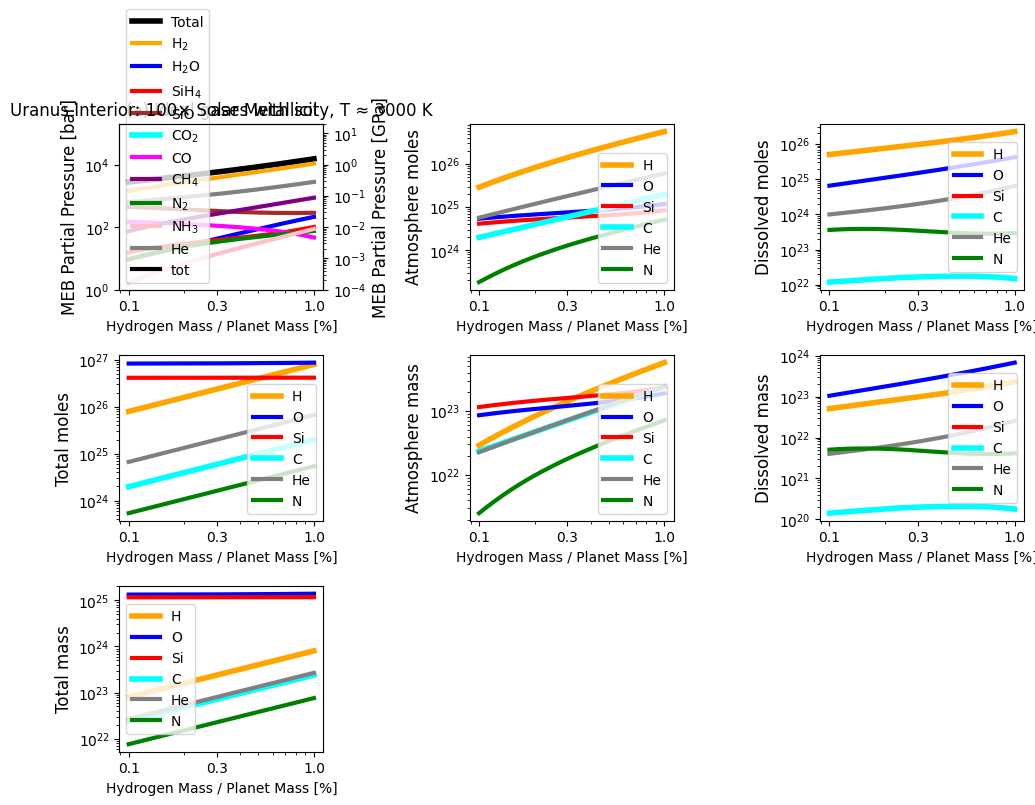

In [32]:
temperatures = [2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000]
init_metallicity = [1, 3, 10, 30, 100]
for surface_temperature in temperatures:
    for metall in init_metallicity:
        mass_constraints = {
            "H": h_kgs,
            "He": he_kgs_solar,
            "C": metall * c_kgs_solar,
            "N": metall * n_kgs_solar,
            "Si": metall * si_kgs_solar + mantle_melt_fraction * si_kg_magma,
            "O": metall * o_kgs_solar + mantle_melt_fraction * o_kg_magma,
                }
        create_models(surface_temperature, planet_mass, mantle_melt_fraction, surface_radius, mass_constraints)